In [1]:
# Imports
import pandas as pd
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
import json
import os
import openpyxl
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

# Data loader and analiser class

## Previous version

In [2]:
class Crypto_analiser_OLD:
    def __init__(self, data_path: str, data_sheet_in: str, data_sheet_out: str = '', network :str = ''):
        self.data_path = data_path
        self.data_sheet = data_sheet_in

        # Autmatically load the given data
        self.possible_networks = ['ETH', 'BSC'] 
        self.data_transfers_in = self.load_reference(data_path, data_sheet_in)
        self.data_transfers_out = self.load_reference(data_path, data_sheet_out)

        self.network_type = self.data_transfers_in['network'][0]
        if self.network_type not in self.possible_networks:
            warnings.warn('The network type is not defined!')
        self.network_type = network + self.network_type

    def load_reference(self, data_path: str, data_sheet: str):
        df = pd.read_excel(data_path, sheet_name=data_sheet)
        df = self.reformat_input_data(df)
        return df

    def reformat_input_data(self, df: pd.DataFrame):
        if 'payment_wallet' in df.keys():
            # incoming payments
            df['payment_wallet'] = df['payment_wallet'].fillna(method='bfill')
            df['payment_wallet'] = df['payment_wallet'].astype(str).str.lower()
        df['from_address'] = df['from_address'].astype(str).str.lower()
        df['to_address'] = df['to_address'].astype(str).str.lower()
        df['value_in_usd'] = df['value_in_usd'].astype(float)

        # Dropping min/max
        df = df[df['network'].isin(self.possible_networks)]
        
        return df


    def make_all_plots(self):
        self.all_transaction_values(self.data_transfers_in, self.data_transfers_out)
        self.common_buyers(self.data_transfers_in, bins = 50)
        self.most_amount_buyers(self.data_transfers_in, bins = 50)

        self.wallet_transfer_amount_and_count(self.data_transfers_out, self.data_transfers_in)

    def all_transaction_values(self, data_transfers_in, data_transfers_out):
        #Logaritmus miatt meg kell szűrni az adatokat
        filtered_in_transfers  = data_transfers_in[data_transfers_in['value_in_usd'] > 0]['value_in_usd']
        filtered_out_transfers = data_transfers_out[data_transfers_out['value_in_usd'] > 0]['value_in_usd']

        # Making the plot
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

        axes[0].hist(np.log10(filtered_in_transfers), bins=50, color='skyblue', edgecolor='black')
        axes[0].set_title('Distribution of Transaction Values (Presale buy)')
        axes[0].set_xlabel('Transaction Value (USD)')
        axes[0].set_ylabel('Frequency')
        axes[0].grid(axis='y', alpha=0.75)

        x_formatter = FuncFormatter(lambda x, pos: '${:,.0f}'.format(10**x))
        axes[0].xaxis.set_major_formatter(x_formatter)

        y_formatter = FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))
        axes[0].yaxis.set_major_formatter(y_formatter)

        ticks = [1, 2, 3, 4, 5, 6]
        axes[0].set_xticks(ticks)

        axes[1].hist(np.log10(filtered_out_transfers), bins=50, color='lightgreen', edgecolor='black')
        axes[1].set_title('Distribution of Transaction Values (Wallet transfers)')
        axes[1].set_xlabel('Transaction Value (USD)')
        axes[1].set_ylabel('Frequency')
        axes[1].grid(axis='y', alpha=0.75)
        axes[1].xaxis.set_major_formatter(x_formatter)
        axes[1].set_xticks(ticks)
        plt.tight_layout()
        plt.savefig(f'../Presale_plots/{self.network_type}_eth_all_transaction_values.pdf')
        plt.show()
    
    def plot_distribution(self, unique_addresses, values, ylabel, title, yticks, formatter, filename):
        plt.figure(figsize=(10, 6))
        plt.scatter(unique_addresses, values, color='skyblue', edgecolor='black')
        plt.title(title)
        plt.xlabel('')
        plt.ylabel(ylabel)
        plt.grid(axis='y', alpha=0.75)
        plt.gca().yaxis.set_major_formatter(formatter)
        plt.yticks(yticks)
        plt.xticks([])
        plt.savefig(filename)
        plt.show()

    def common_buyers(self, data_transfers_in, bins=50):
        data_transfers_in['address_pair'] = data_transfers_in.apply(lambda row: tuple(sorted([row['from_address'], row['to_address']])), axis=1)

        transaction_counts = data_transfers_in.groupby('address_pair').size()
        transaction_counts_df = transaction_counts.reset_index(name='transaction_count')

        top_n_transactions = transaction_counts_df.nlargest(bins, 'transaction_count')
        top_n_transactions[['from_address', 'to_address']] = top_n_transactions['address_pair'].apply(pd.Series)
        top_n_transactions.drop('address_pair', axis=1, inplace=True)

        unique_addresses = list(set(top_n_transactions['to_address'].values.tolist() + top_n_transactions['from_address'].values.tolist()))[:-1]

        values = np.log10(top_n_transactions['transaction_count'])
        ylabel = 'Frequency'
        title = 'Distribution of number of transactions per addresses'
        formatter = FuncFormatter(lambda x, pos: '{:,.0f}'.format(10**x))
        yticks = [1, 2, 3, 4]
        filename = f'../Presale_plots/{self.network_type}_top_frequency.pdf'

        self.plot_distribution(unique_addresses, values, ylabel, title, yticks, formatter, filename)

    def most_amount_buyers(self, data_transfers_in, bins=50):
        data_transfers_in['address_pair'] = data_transfers_in.apply(lambda row: tuple(sorted([row['from_address'], row['to_address']])), axis=1)
        sum_of_value_of_transactions = data_transfers_in.groupby('address_pair')['value_in_usd'].sum().reset_index()

        top_n_value = sum_of_value_of_transactions.nlargest(bins, 'value_in_usd')
        top_n_value[['from_address', 'to_address']] = top_n_value['address_pair'].apply(pd.Series)
        top_n_value.drop('address_pair', axis=1, inplace=True)

        unique_addresses = list(set(top_n_value['to_address'].values.tolist() + top_n_value['from_address'].values.tolist()))[:-1]

        values = np.log10(top_n_value['value_in_usd'])
        ylabel = 'Value'
        title = 'Distribution of biggest value of transactions per addresses'
        formatter = FuncFormatter(lambda x, pos: '${:,.0f}'.format(10**x))
        yticks = [4, 5, 6]
        filename = f'../Presale_plots/{self.network_type}_top_values.pdf'

        self.plot_distribution(unique_addresses, values, ylabel, title, yticks, formatter, filename)

    def wallet_transfer_amount_and_count(self, data_transfers_out, data_transfers_in):
        unique_payment_wallets    = data_transfers_in['payment_wallet'].unique()
        filtered_wallet_transfers = data_transfers_out[data_transfers_out['from_address'].isin(unique_payment_wallets)]

        #Idő szerint mikor mentek az utalások és mekkora összeggel
        transfer_summary = filtered_wallet_transfers.groupby(['from_address', 'to_address']).agg({'value_in_usd': ['count', 'sum'],
                                                                                                    'timestamp': ['min', 'max']}).reset_index()

        transfer_summary.columns = ['From Address', 'To Address', 'Transaction Count', 'Total Value USD', 'Earliest Transaction', 'Latest Transaction']

        transfer_summary['Earliest Transaction'] = pd.to_datetime(transfer_summary['Earliest Transaction'], unit = 's')
        transfer_summary['Latest Transaction']   = pd.to_datetime(transfer_summary['Latest Transaction'], unit = 's')

        # TODO ????unique_addresses = list(set(transfer_summary['From Address'].values.tolist() + transfer_summary['To Address'].values.tolist()))[:-1]
        unique_addresses = list(transfer_summary['To Address'].values.tolist())

        #Létrehozni a plotot
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

        #Elnevezzük csak a dolgokat + itt csinálunk log-os átalakítást
        transfer_summary.sort_values('Total Value USD', inplace = True, axis = 0, ascending = False)
        print('unique: ', len(unique_addresses), 'transfer_sum: ', len(transfer_summary))
        axes[0].scatter(unique_addresses, np.log10(transfer_summary['Total Value USD']), color='skyblue', edgecolor='black')
        axes[0].set_title('Distribution of biggest value of transactions per addresses (Wallet transfers)')
        axes[0].set_xlabel('')
        axes[0].set_ylabel('Value')
        axes[0].grid(axis='y', alpha=0.75)

        formatter = FuncFormatter(lambda x, pos: '${:,.0f}'.format(10**x))
        axes[0].yaxis.set_major_formatter(formatter)

        #X tengelyt még át kell alakítani, a ticks adja meg, hogy a 10 a hányadikonok legyenek a tengelyen
        ticks = [2, 3, 4, 5, 6, 7]
        axes[0].set_yticks(ticks)
        axes[0].set_xticks('')

        #Teljesen ugyanaz mint előbb
        transfer_summary.sort_values('Transaction Count', inplace = True, axis = 0, ascending = False)
        axes[1].scatter(unique_addresses, transfer_summary['Transaction Count'], color='skyblue', edgecolor='black')
        axes[1].set_title('Distribution of number of transactions per addresses (Wallet transfers)')
        axes[1].set_xlabel('')
        axes[1].set_ylabel('Frequency')
        axes[1].grid(axis='y', alpha=0.75)
        axes[1].set_xticks('')

        #Ábrázolás
        plt.tight_layout()
        plt.savefig(f'../Presale_plots/{self.network_type}_wallet_transfers_stats.pdf')
        plt.show()

    def time_factor(self, data_transfers_out, data_transfers_in):
        pass



## New version

In [3]:
class Crypto_analiser:
    def __init__(self, data_path: str, data_sheet_in: str, data_sheet_out: str = '', network: str = ''):
        self.data_path = data_path
        self.data_sheet = data_sheet_in

        # Autmatically load the given data
        self.possible_networks = ['ETH', 'BSC']
        self.data_transfers_in = self.load_reference(data_path, data_sheet_in)
        self.data_transfers_out = self.load_reference(data_path, data_sheet_out)

        self.network_type = self.data_transfers_in['network'][0]
        if self.network_type not in self.possible_networks:
            warnings.warn('The network type is not defined!')
        self.network_type = network + self.network_type

    def load_reference(self, data_path: str, data_sheet: str):
        df = pd.read_excel(data_path, sheet_name=data_sheet)
        df = self.reformat_input_data(df)
        return df

    def reformat_input_data(self, df: pd.DataFrame):
        if 'payment_wallet' in df.keys():
            # incoming payments
            df['payment_wallet'] = df['payment_wallet'].fillna(method='bfill')
            df['payment_wallet'] = df['payment_wallet'].astype(str).str.lower()
        df['from_address'] = df['from_address'].astype(str).str.lower()
        df['to_address'] = df['to_address'].astype(str).str.lower()
        df['value_in_usd'] = df['value_in_usd'].astype(float)

        # Dropping min/max
        df = df[df['network'].isin(self.possible_networks)]

        return df

    def make_all_plots(self):
        self.all_transaction_values(self.data_transfers_in, self.data_transfers_out)
        self.common_buyers(self.data_transfers_in, bins=50)
        self.most_amount_buyers(self.data_transfers_in, bins=50)
        self.wallet_transfer_amount_and_count(self.data_transfers_out, self.data_transfers_in)
        self.time_factor(self.data_transfers_out, self.data_transfers_in)

    def all_transaction_values(self, data_transfers_in, data_transfers_out):
        # Logaritmus miatt meg kell szűrni az adatokat
        filtered_in_transfers = data_transfers_in[data_transfers_in['value_in_usd'] > 0]['value_in_usd']
        filtered_out_transfers = data_transfers_out[data_transfers_out['value_in_usd'] > 0]['value_in_usd']

        # Making the plot
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

        axes[0].hist(np.log10(filtered_in_transfers), bins=50, color='skyblue', edgecolor='black')
        axes[0].set_title('Distribution of Transaction Values (Presale buy)')
        axes[0].set_xlabel('Transaction Value (USD)')
        axes[0].set_ylabel('Frequency')
        axes[0].grid(axis='y', alpha=0.75)

        x_formatter = FuncFormatter(lambda x, pos: '${:,.0f}'.format(10 ** x))
        axes[0].xaxis.set_major_formatter(x_formatter)

        y_formatter = FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))
        axes[0].yaxis.set_major_formatter(y_formatter)

        ticks = [1, 2, 3, 4, 5, 6]
        axes[0].set_xticks(ticks)

        axes[1].hist(np.log10(filtered_out_transfers), bins=50, color='lightgreen', edgecolor='black')
        axes[1].set_title('Distribution of Transaction Values (Wallet transfers)')
        axes[1].set_xlabel('Transaction Value (USD)')
        axes[1].set_ylabel('Frequency')
        axes[1].grid(axis='y', alpha=0.75)
        axes[1].xaxis.set_major_formatter(x_formatter)
        axes[1].set_xticks(ticks)
        plt.tight_layout()
        plt.savefig(f'../Presale_plots/{self.network_type}all_transaction_values.pdf')
        plt.show()

    def plot_distribution(self, unique_addresses, values, ylabel, title, yticks, formatter, filename):
        plt.figure(figsize=(10, 6))
        plt.scatter(unique_addresses, values, color='skyblue', edgecolor='black')
        plt.title(title)
        plt.xlabel('')
        plt.ylabel(ylabel)
        plt.grid(axis='y', alpha=0.75)
        plt.gca().yaxis.set_major_formatter(formatter)
        plt.yticks(yticks)
        plt.xticks([])
        plt.savefig(filename)
        plt.show()

    def common_buyers(self, data_transfers_in, bins=50):
        data_transfers_in['address_pair'] = data_transfers_in.apply(
            lambda row: tuple(sorted([row['from_address'], row['to_address']])), axis=1)

        transaction_counts = data_transfers_in.groupby('address_pair').size()
        transaction_counts_df = transaction_counts.reset_index(name='transaction_count')

        top_n_transactions = transaction_counts_df.nlargest(bins, 'transaction_count')
        top_n_transactions[['from_address', 'to_address']] = top_n_transactions['address_pair'].apply(pd.Series)
        top_n_transactions.drop('address_pair', axis=1, inplace=True)

        unique_addresses = list(
            set(top_n_transactions['to_address'].values.tolist() + top_n_transactions['from_address'].values.tolist()))[
                           :-1]

        values = np.log10(top_n_transactions['transaction_count'])
        ylabel = 'Frequency'
        title = 'Distribution of number of transactions per addresses'
        formatter = FuncFormatter(lambda x, pos: '{:,.0f}'.format(10 ** x))
        yticks = [1, 2, 3, 4]
        filename = f'../Presale_plots/{self.network_type}_top_frequency.pdf'

        self.plot_distribution(unique_addresses, values, ylabel, title, yticks, formatter, filename)

    def most_amount_buyers(self, data_transfers_in, bins=50):
        data_transfers_in['address_pair'] = data_transfers_in.apply(
            lambda row: tuple(sorted([row['from_address'], row['to_address']])), axis=1)
        sum_of_value_of_transactions = data_transfers_in.groupby('address_pair')['value_in_usd'].sum().reset_index()

        top_n_value = sum_of_value_of_transactions.nlargest(bins, 'value_in_usd')
        top_n_value[['from_address', 'to_address']] = top_n_value['address_pair'].apply(pd.Series)
        top_n_value.drop('address_pair', axis=1, inplace=True)

        unique_addresses = list(
            set(top_n_value['to_address'].values.tolist() + top_n_value['from_address'].values.tolist()))[:-1]

        values = np.log10(top_n_value['value_in_usd'])
        ylabel = 'Value'
        title = 'Distribution of biggest value of transactions per addresses'
        formatter = FuncFormatter(lambda x, pos: '${:,.0f}'.format(10 ** x))
        yticks = [4, 5, 6]
        filename = f'../Presale_plots/{self.network_type}_top_values.pdf'

        self.plot_distribution(unique_addresses, values, ylabel, title, yticks, formatter, filename)

    def wallet_transfer_amount_and_count(self, data_transfers_out, data_transfers_in):
        unique_payment_wallets = data_transfers_in['payment_wallet'].unique()
        filtered_wallet_transfers = data_transfers_out[data_transfers_out['from_address'].isin(unique_payment_wallets)]

        # Idő szerint mikor mentek az utalások és mekkora összeggel
        transfer_summary = filtered_wallet_transfers.groupby(['from_address', 'to_address']).agg(
            {'value_in_usd': ['count', 'sum'],
             'timestamp': ['min', 'max']}).reset_index()

        transfer_summary.columns = ['From Address', 'To Address', 'Transaction Count', 'Total Value USD',
                                    'Earliest Transaction', 'Latest Transaction']

        transfer_summary['Earliest Transaction'] = pd.to_datetime(transfer_summary['Earliest Transaction'], unit='s')
        transfer_summary['Latest Transaction'] = pd.to_datetime(transfer_summary['Latest Transaction'], unit='s')

        # TODO ????unique_addresses = list(set(transfer_summary['From Address'].values.tolist() + transfer_summary['To Address'].values.tolist()))[:-1]
        unique_addresses = list(transfer_summary['To Address'].values.tolist())

        # Létrehozni a plotot
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

        # Elnevezzük csak a dolgokat + itt csinálunk log-os átalakítást
        transfer_summary.sort_values('Total Value USD', inplace=True, axis=0, ascending=False)
        print('unique: ', len(unique_addresses), 'transfer_sum: ', len(transfer_summary))
        axes[0].scatter(unique_addresses, np.log10(transfer_summary['Total Value USD']), color='skyblue',
                        edgecolor='black')
        axes[0].set_title('Distribution of biggest value of transactions per addresses (Wallet transfers)')
        axes[0].set_xlabel('')
        axes[0].set_ylabel('Value')
        axes[0].grid(axis='y', alpha=0.75)

        formatter = FuncFormatter(lambda x, pos: '${:,.0f}'.format(10 ** x))
        axes[0].yaxis.set_major_formatter(formatter)

        # X tengelyt még át kell alakítani, a ticks adja meg, hogy a 10 a hányadikonok legyenek a tengelyen
        ticks = [2, 3, 4, 5, 6, 7]
        axes[0].set_yticks(ticks)
        axes[0].set_xticks('')

        # Teljesen ugyanaz mint előbb
        transfer_summary.sort_values('Transaction Count', inplace=True, axis=0, ascending=False)
        axes[1].scatter(unique_addresses, transfer_summary['Transaction Count'], color='skyblue', edgecolor='black')
        axes[1].set_title('Distribution of number of transactions per addresses (Wallet transfers)')
        axes[1].set_xlabel('')
        axes[1].set_ylabel('Frequency')
        axes[1].grid(axis='y', alpha=0.75)
        axes[1].set_xticks('')

        # Ábrázolás
        plt.tight_layout()
        plt.savefig(f'../Presale_plots/{self.network_type}_wallet_transfers_stats.pdf')
        plt.show()

    def time_factor(self, data_transfers_out, data_transfers_in):
        bins = 50
        bins += 1
        X_in = data_transfers_in['timestamp']
        X_out = data_transfers_out['timestamp']
        time_min = min(data_transfers_out['timestamp'].min(), data_transfers_in['timestamp'].min())
        time_max = max(data_transfers_out['timestamp'].max(), data_transfers_in['timestamp'].max())
        times = np.arange(time_min, time_max, (time_max - time_min) / bins)

        Y_in = data_transfers_in['value_in_usd']
        Y_out = data_transfers_out['value_in_usd']

        # Aggregating the data
        Y_in_aggregated = [sum([Y_in[j] for j in range(len(X_in)) if times[i] <= X_in[j] < times[i+1]])
                           for i in range(len(times) - 1)]
        Y_out_aggregated = [sum([Y_out[j] for j in range(len(X_out)) if times[i] <= X_out[j] < times[i+1]])
                           for i in range(len(times) - 1)]

        # Plot bars
        plt.plot(times[:-1], Y_in_aggregated, color='red', label='Income')
        plt.plot(times[:-1], Y_out_aggregated, color='blue', label='Outcome')

        # Add labels and legend
        plt.xlabel('Timestamp')
        plt.ylabel('Value (USD)')
        plt.title('Income and Outcome over Time')
        plt.legend()
        plt.tight_layout()

        # Show plot
        plt.savefig(f'../Presale_plots/{self.network_type}time_factor.pdf')
        plt.show()

# Inspecting intersections

## Defining functions

In [24]:
def find_elements_in_at_least_two(arrays, source_names):
    # Initialize a counter
    element_count = {}
    
    # Convert each array to a set and update the counter
    for i in range(len(arrays)):
        unique_elements = set(arrays[i])
        for element in unique_elements:
            if element in element_count:
                if source_names[i] not in element_count[element][1]:
                    element_count[element][0] += 1
                    element_count[element][1].append(source_names[i])
            else:
                element_count[element] = [1, [source_names[i]]]
    
    # Find elements that appear in at least 2 arrays
    common_elements = {element: item for element, item in element_count.items() if item[0] > 1 and element is not np.nan}
    
    return common_elements

def similar_buyer_wallets_presale(all_data_source: list, source_names: list):
    all_buyers = []
    for data in all_data_source:
        list_of_buyers = pd.read_excel(data['data_path'], sheet_name=data['data_sheet'])['from_address'].to_numpy()
        all_buyers.append(list_of_buyers)

    return find_elements_in_at_least_two(all_buyers, source_names)

## 2 way intersection

In [25]:
# Testing similar_buyer_wallets_presale function

all_data_source = [{'data_path': '../Data/DATA_Love_Hate_Inu_presale.xlsx', 'data_sheet': 'lhinu_presale_buy_result_167775'}, 
                   {'data_path': '../Data/DATA_Love_Hate_Inu_presale.xlsx', 'data_sheet': 'lhinu_bsc_presale_buys_26487457'}, 
                   {'data_path': '../Data/Thug_Life_token_presale.xlsx', 'data_sheet': 'thug_presale_buy_result_1756436'},
                   {'data_path': '../Data/Wall_Street_Memes_presale.xlsx', 'data_sheet': 'wsm_presale_buy_result_bsc_2851'},
                   {'data_path': '../Data/Wall_Street_Memes_presale.xlsx', 'data_sheet': 'wsm_presale_buy_result_eth_1733'}]

source_names = ['LHlnu', 'LHlnu', 'Thug_life_token', 'Wall_Street_Memes', 'Wall_Street_Memes']
same_wallets = similar_buyer_wallets_presale(all_data_source, source_names)
print(same_wallets)
print(len(same_wallets))

{'0x114691eb826706c86a3339194c5b9e308eb64cf5': [2, ['LHlnu', 'Wall_Street_Memes']], '0x9005b6ffad747b1a74bd89ed0fbdb1b7439420ef': [2, ['LHlnu', 'Wall_Street_Memes']], '0x655a189af6e0bedbae45b5475184b0b32b1ac595': [2, ['LHlnu', 'Wall_Street_Memes']], '0xc93f7f758c5e4efccaa4d1db88d4e95c02ed8cd5': [2, ['LHlnu', 'Wall_Street_Memes']], '0x23e34d692e0682e89f1ee83ff4b10f4d739c87b0': [2, ['LHlnu', 'Wall_Street_Memes']], '0x92d3c2b684c4d318746bb37518ecd98205c0cb42': [2, ['LHlnu', 'Wall_Street_Memes']], '0xb7b3f9da1417d8308e9482be4029e575c04e39c2': [2, ['LHlnu', 'Wall_Street_Memes']], '0x3563ac7fa7c741891b791cffe0effda0401a64ae': [2, ['LHlnu', 'Wall_Street_Memes']], '0xf3068d028f6104249f973c3888b5ee4da1006fa9': [2, ['LHlnu', 'Thug_life_token']], '0xf65fae9b8dc6ab82ed9c50ba356c3f40cf808bea': [2, ['LHlnu', 'Wall_Street_Memes']], '0x7cf1b9fe4d33f7ab9b6a14a1bcf1f9190cf2e744': [2, ['LHlnu', 'Wall_Street_Memes']], '0xb5cff872bf36ed55ab8c9540e0e6122f5f637abc': [2, ['LHlnu', 'Wall_Street_Memes']], '0x81

{'0x86705b1a4427823da45c86c75df3ae9b1fc6b721': [114.81453, 0.0, 72.9358, 63.0069, 0.0], '0x8da5592e3f9b50fac580b88b30402c87c6d17665': [26.65, 0.0, 12.8198, 0.0, 32.5], '0x78921856cea44204db75ecfd3dd8125ed78b1208': [198.498185, 0.0, 126.028, 0.0, 304.7564], '0xd72c79dbb46e0ef6d672c188cc1d4ff6af41cb2a': [109.72602, 0.0, 478.5627, 0.0, 611.9848], '0x99212964b39b7e4994a9a8d5e75bd70e67c77d88': [66.75017, 0.0, 60.922399999999996, 0.0, 106.0555], '0x3a92d1a1f11c1f585cb41c555b482dcc6a69ea6b': [729.117305, 0.0, 253.0836, 0.0, 1527.0556000000001], '0x2a58816bcc688e4c588436d638116387c9758f59': [180.97956, 245.70003499999999, 153.9097, 522.0000000000001, 1704.2655], '0x3d94d71b96681658bed8c5a78ed353f0ef64be75': [5725.30249, 0.0, 454.0193, 0.0, 963.4048], '0xcc31ead3f7a81826c060da52bcaf7337128832cb': [206.77988499999998, 0.0, 280.0, 0.0, 1611.9625], '0x09be769f7903c2e9fa40d514e156cee6f7b55839': [60.691995, 0.0, 49.5565, 0.0, 28.582], '0x08a8616b752c3a00102acdcbfa290bd494de1d91': [114.29654, 0.0, 11

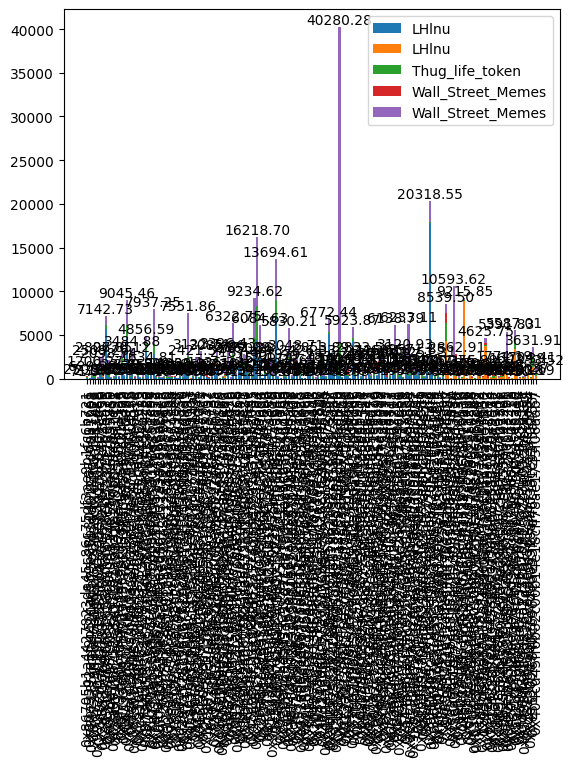

In [29]:
sus_wallets = [x for x in same_wallets if same_wallets[x][0] >=3]

def inspect_list_of_buyers(all_data_source: list, source_names: list, buyers):
    all_buyers = {}
    moneys_spent = {x: [0] * len(all_data_source) for x in buyers}  # Track spending by each buyer for each data source

    for i in range(len(all_data_source)):
        data = all_data_source[i]
        df = pd.read_excel(data['data_path'], sheet_name=data['data_sheet'])
        for buyer in buyers:
            this_buyer = df[df['from_address'] == buyer]
            all_buyers[(buyer, source_names[i])] = this_buyer
            money_spent = this_buyer['value_in_usd'].sum()
            moneys_spent[buyer][i] = money_spent
    


    ax.legend()  # Add legend to differentiate data sources
    plt.show()

    return all_buyers

buyer_specific_data = inspect_list_of_buyers(all_data_source, source_names, sus_wallets)

## 4 way intersection

In [5]:
# Testing similar_buyer_wallets_presale function

all_data_source = [{'data_path': '../Data/DATA_Love_Hate_Inu_presale.xlsx', 'data_sheet': 'lhinu_presale_buy_result_167775'}, 
                   {'data_path': '../Data/DATA_Love_Hate_Inu_presale.xlsx', 'data_sheet': 'lhinu_bsc_presale_buys_26487457'}, 
                   {'data_path': '../Data/Thug_Life_token_presale.xlsx', 'data_sheet': 'thug_presale_buy_result_1756436'},
                   {'data_path': '../Data/Wall_Street_Memes_presale.xlsx', 'data_sheet': 'wsm_presale_buy_result_bsc_2851'}]

source_names = ['LHlnu_eth', 'LHlnu_bsc', 'Thug_life_token', 'Wall_Street_Memes']
same_wallets = similar_buyer_wallets_presale(all_data_source, source_names)
print(same_wallets)
print(len(same_wallets))

{'0xc7bffdbdfd3f6505088e8f3b1717e7f1b8382f3a': [2, ['LHlnu_eth', 'LHlnu_bsc']], '0x13a5d34e36d56a0e72f1501f5887168905b182ec': [2, ['LHlnu_eth', 'LHlnu_bsc']], '0x100e24ce56f2757d83e818b04dd91fe92719b71c': [2, ['LHlnu_eth', 'LHlnu_bsc']], '0x84b811cc1005eac05eff2738addf9b961da252d5': [2, ['LHlnu_eth', 'LHlnu_bsc']], '0x495f261d31c8ef2a4f0b7143610b11d0be18ee72': [2, ['LHlnu_eth', 'LHlnu_bsc']], '0xc93f7f758c5e4efccaa4d1db88d4e95c02ed8cd5': [2, ['LHlnu_eth', 'Wall_Street_Memes']], '0x7bd815137bdf0824acfb2dcee72de909e0054da1': [2, ['LHlnu_eth', 'LHlnu_bsc']], '0x9622dc4a39c2be415fa926e16e4e5f99a5c3a81c': [2, ['LHlnu_eth', 'LHlnu_bsc']], '0xf3068d028f6104249f973c3888b5ee4da1006fa9': [2, ['LHlnu_eth', 'Thug_life_token']], '0x82b393ff5e585e903bd2e61373b69e34a6987cb0': [2, ['LHlnu_eth', 'LHlnu_bsc']], '0x81671c9329d04ea818bd2c8e00d9ec500b48f55f': [2, ['LHlnu_eth', 'Wall_Street_Memes']], '0xd841567e7213f44ad7736a8be6df6e9207c5db36': [2, ['LHlnu_eth', 'Wall_Street_Memes']], '0x970d04be25a71f0b16

[74, 1936, 170, 1961]


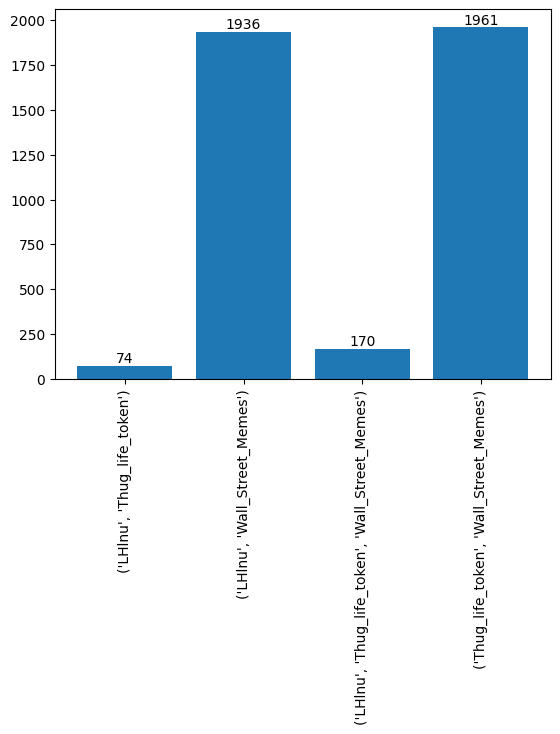

In [30]:
# Visualizing the result above:
pairs = sorted([tuple(sorted(same_wallets[x][1])) for x in same_wallets])

X = [str(x) for x in list(set(pairs))]
Y = [pairs.count(x) for x in list(set(pairs))]
print(Y)

# Create the bar plot
fig, ax = plt.subplots()
bars = ax.bar(X, Y)

# Rotate X-axis labels to horizontal
plt.xticks(rotation=90)

# Add text annotations on top of the bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}', ha='center', va='bottom')

# Show the plot
plt.show()

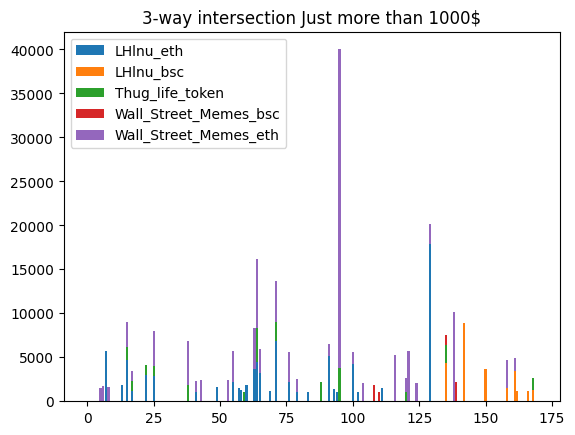

In [43]:
# Showing some wallets which had both LHlnu and Wall street memes and Thug life token
intersection_wallets = [x for x in same_wallets if len(set(same_wallets[x][1])) >=3]

def inspect_list_of_buyers(all_data_source: list, source_names: list, buyers):
    all_buyers = {}
    moneys_spent = {x: [0] * len(all_data_source) for x in buyers}  # Track spending by each buyer for each data source

    for i in range(len(all_data_source)):
        data = all_data_source[i]
        df = pd.read_excel(data['data_path'], sheet_name=data['data_sheet'])
        for buyer in buyers:
            this_buyer = df[df['from_address'] == buyer]
            all_buyers[(buyer, source_names[i])] = this_buyer
            money_spent = this_buyer['value_in_usd'].sum()
            moneys_spent[buyer][i] = money_spent

    # Prepare data for plotting
    buyers_list = list(buyers)
    data_sources = len(all_data_source)
    ind = np.arange(len(buyers))  # the x locations for the groups
    bottom = np.zeros(len(buyers))  # Starting bottom for each buyer's bar

    fig, ax = plt.subplots()

    for i in range(data_sources):
        amounts = [moneys_spent[buyer][i] for buyer in buyers_list]
        filtered_amounts = [amount if amount > 1000 else 0 for amount in amounts]
        bars = ax.bar(ind, filtered_amounts, bottom=bottom, label=source_names[i])
        bottom += np.array(filtered_amounts)  # Update bottom for next data source

    ax.legend()  # Add legend to differentiate data sources
    plt.title('3-way intersection Just more than 1000$')
    plt.show()

    return all_buyers

buyer_specific_data = inspect_list_of_buyers(all_data_source, ['LHlnu_eth', 'LHlnu_bsc', 'Thug_life_token', 'Wall_Street_Memes_bsc', 'Wall_Street_Memes_eth'], intersection_wallets)

In [52]:
buyer_specific_data

{('0x86705b1a4427823da45c86c75df3ae9b1fc6b721',
  'LHlnu_eth'):       network  value_in_usd     timestamp            datetime_utc  \
 18871     ETH     114.81453  1.682680e+09 2023-04-28 11:01:11.424   
 
                                      from_address  \
 18871  0x86705b1a4427823da45c86c75df3ae9b1fc6b721   
 
                                        to_address  \
 18871  0x17b1e028a1837ff15ba9e7140add0d13790092a3   
 
                                    payment_wallet  \
 18871  0x99a2770b5c9337f44a00a7677471373c89bf0f36   
 
                                                  tx_hash  
 18871  0x144d9e6d502e579f92dd867ec9e520404d8c0567f666...  ,
 ('0x8da5592e3f9b50fac580b88b30402c87c6d17665',
  'LHlnu_eth'):       network  value_in_usd     timestamp            datetime_utc  \
 7378      ETH         23.75  1.680347e+09 2023-04-01 11:09:35.136   
 22116     ETH          2.90  1.682972e+09 2023-05-01 20:18:47.232   
 
                                      from_address  \
 7378   0x8da55

In [53]:
max({x:buyer_specific_data[x] for x in buyer_specific_data if x[1] == 'Wall_Street_Memes_eth'}, key=lambda y:buyer_specific_data[y]['value_in_usd'].sum())

('0x338e3b5befcff7d093657a8289db8eddaefb0b7b', 'Wall_Street_Memes_eth')

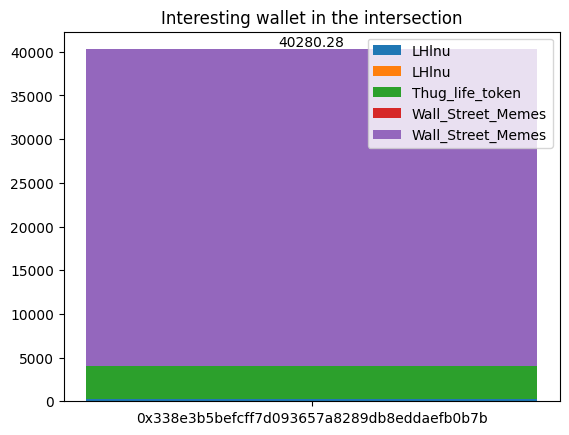

In [55]:
sus_wallets = ['0x338e3b5befcff7d093657a8289db8eddaefb0b7b']

def inspect_list_of_buyers(all_data_source: list, source_names: list, buyers):
    all_buyers = {}
    moneys_spent = {x: [0] * len(all_data_source) for x in buyers}  # Track spending by each buyer for each data source

    for i in range(len(all_data_source)):
        data = all_data_source[i]
        df = pd.read_excel(data['data_path'], sheet_name=data['data_sheet'])
        for buyer in buyers:
            this_buyer = df[df['from_address'] == buyer]
            all_buyers[(buyer, source_names[i])] = this_buyer
            money_spent = this_buyer['value_in_usd'].sum()
            moneys_spent[buyer][i] = money_spent

    # Prepare data for plotting
    buyers_list = list(buyers)
    data_sources = len(all_data_source)
    ind = np.arange(len(buyers))  # the x locations for the groups
    bottom = np.zeros(len(buyers))  # Starting bottom for each buyer's bar

    fig, ax = plt.subplots()

    for i in range(data_sources):
        amounts = [moneys_spent[buyer][i] for buyer in buyers_list]
        bars = ax.bar(ind, amounts, bottom=bottom, label=source_names[i])
        bottom += np.array(amounts)  # Update bottom for next data source

    # Rotate X-axis labels to vertical
    plt.xticks(ind, buyers_list, rotation=0)

    # Add text annotations on top of the bars
    for buyer_idx, buyer in enumerate(buyers_list):
        height = bottom[buyer_idx]
        ax.text(buyer_idx, height, f'{height:.2f}', ha='center', va='bottom')

    plt.title('Interesting wallet in the intersection')
    ax.legend()  # Add legend to differentiate data sources
    plt.show()

    return all_buyers

buyer_specific_data = inspect_list_of_buyers(all_data_source, source_names, sus_wallets)

In [8]:
buyer_specific_data[('0xdc05337152ec0e7f42192a5147e22c1c34dbc4aa', 'LHlnu_eth')]

,network,value_in_usd,timestamp,datetime_utc,from_address,to_address,payment_wallet,tx_hash
17862,ETH,97.999875,1.682557e+09,2023-04-27 00:50:47.328,0xdc05337152ec0e7f42192a5147e22c1c34dbc4aa,0x17b1e028a1837ff15ba9e7140add0d13790092a3,0x99a2770b5c9337f44a00a7677471373c89bf0f36,0x09cd1e91aa5eedfccb1fcbfd8b8f36f90028df53268a...


# Using the class to make the plots

## Love Hate LNU

### ETH Data

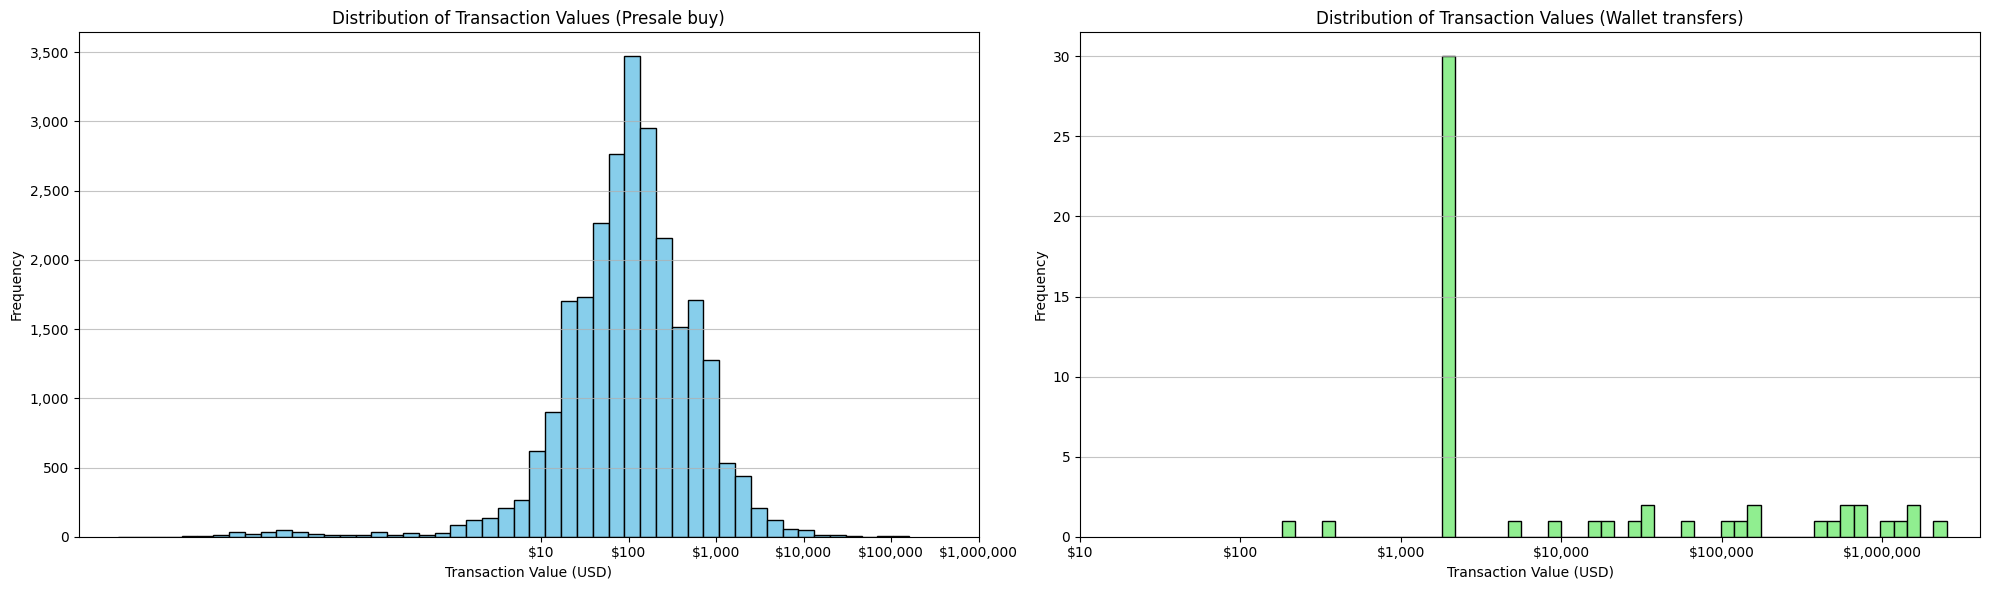

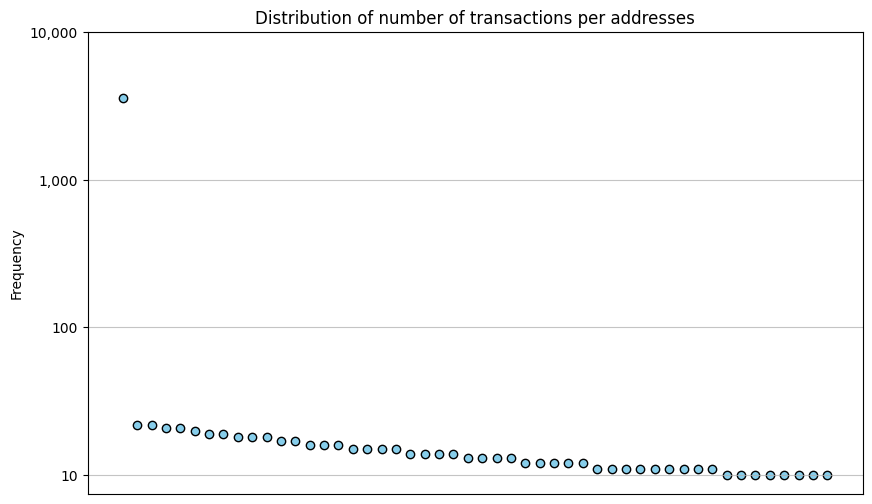

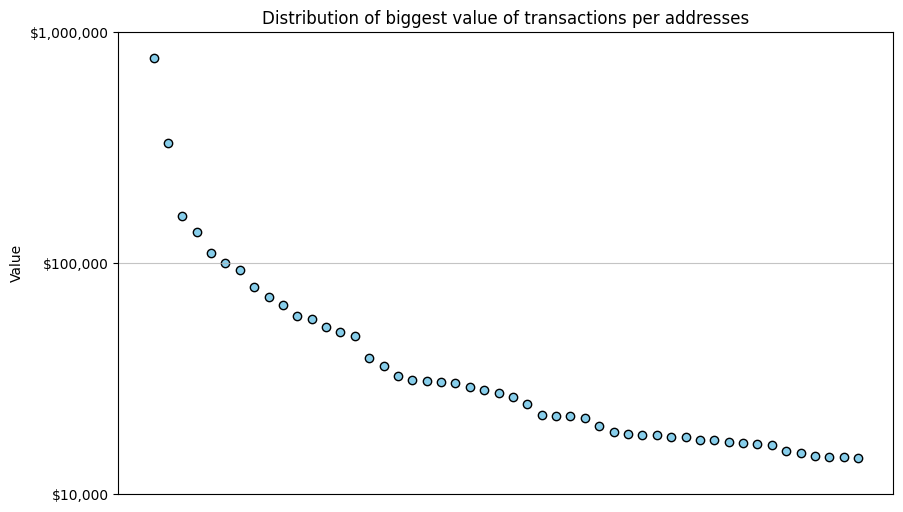

unique:  43 transfer_sum:  43


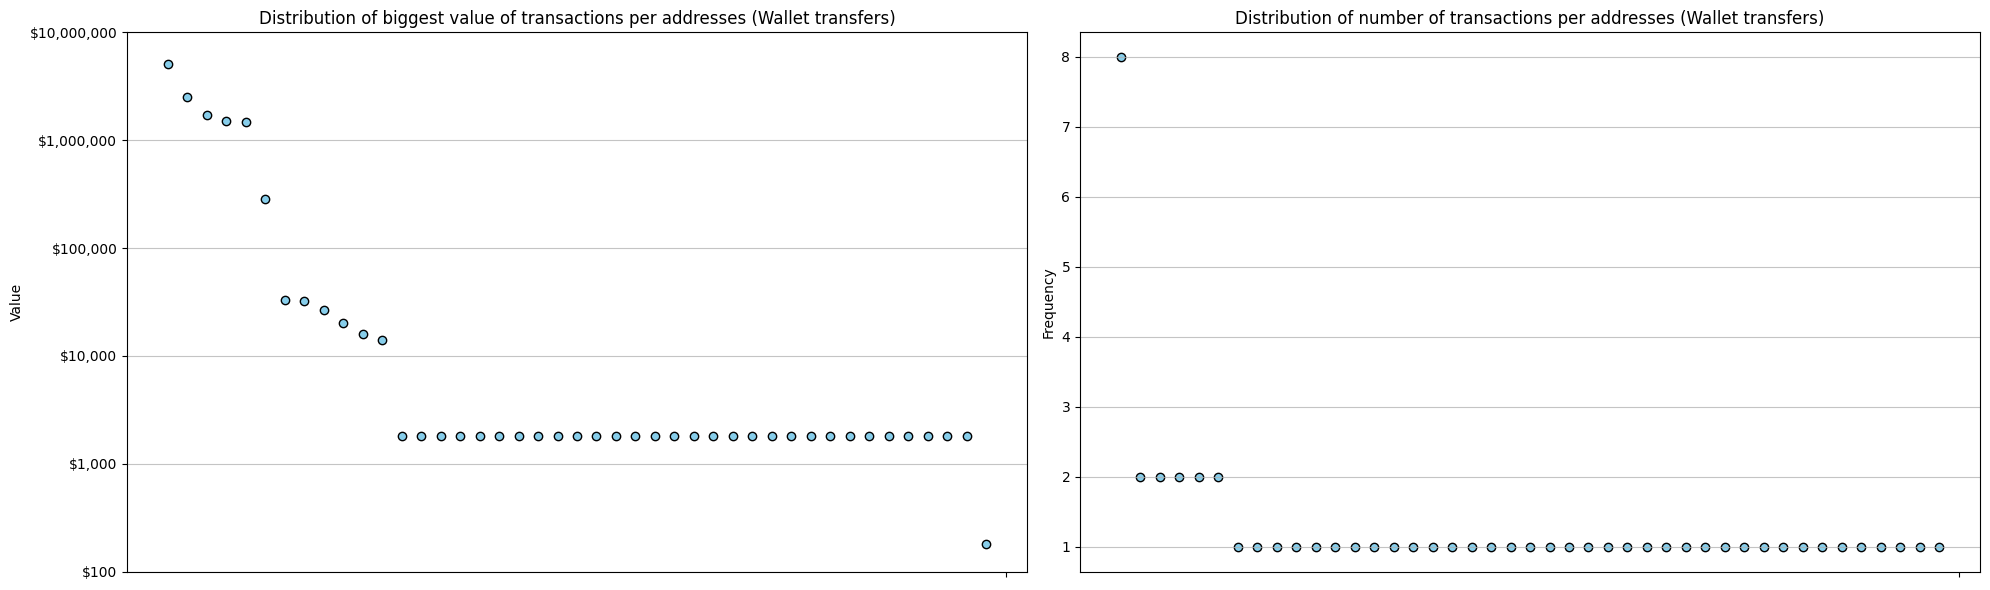

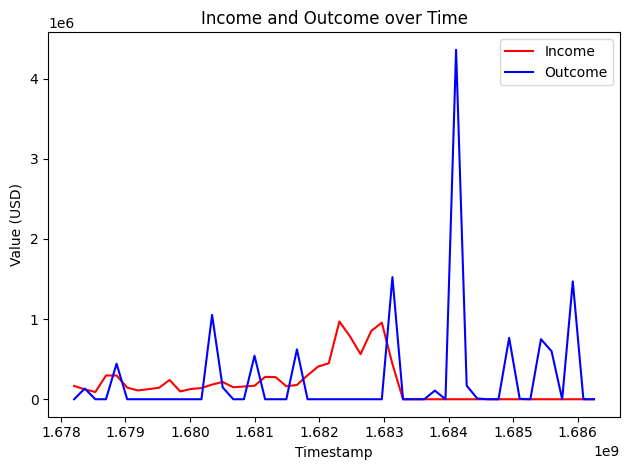

In [9]:
data_path = '../Data/DATA_Love_Hate_Inu_presale.xlsx'
data_sheet_out = 'lhinu_payment_wallet_transfers_'
data_sheet_in = 'lhinu_presale_buy_result_167775'
network = 'Love_Hate_LNU'

analiser = Crypto_analiser(data_path=data_path, 
                                  data_sheet_in=data_sheet_in, 
                                  data_sheet_out=data_sheet_out,
                                  network=network)
analiser.make_all_plots()

,network,value_in_usd,timestamp,datetime_utc,from_address,to_address,payment_wallet,tx_hash,address_pair
0,ETH,20.200250,1.678206e+09,2023-03-07 16:14:58.848,0x13f449f1d18113242f4b4f822fe775eb8dcbfadb,0x17b1e028a1837ff15ba9e7140add0d13790092a3,0x99a2770b5c9337f44a00a7677471373c89bf0f36,0x92820fe482aed078af7ef15f95c0b4fba0e54b232139...,"(0x13f449f1d18113242f4b4f822fe775eb8dcbfadb, 0..."
1,ETH,156.329960,1.678206e+09,2023-03-07 16:25:11.424,0xc501feef312f6a7843334a2bc8eff3cad60b7e25,0x17b1e028a1837ff15ba9e7140add0d13790092a3,0x99a2770b5c9337f44a00a7677471373c89bf0f36,0xe8854101c7e8fd6a40ccb559abca9be537219a2d5c18...,"(0x17b1e028a1837ff15ba9e7140add0d13790092a3, 0..."
2,ETH,156.329960,1.678206e+09,2023-03-07 16:27:22.752,0xc501feef312f6a7843334a2bc8eff3cad60b7e25,0x17b1e028a1837ff15ba9e7140add0d13790092a3,0x99a2770b5c9337f44a00a7677471373c89bf0f36,0x247019f029a53fd824345fdb14233b9bcfb5f1bf4194...,"(0x17b1e028a1837ff15ba9e7140add0d13790092a3, 0..."
3,ETH,85.000000,1.678207e+09,2023-03-07 16:29:10.752,0xc501feef312f6a7843334a2bc8eff3cad60b7e25,0x17b1e028a1837ff15ba9e7140add0d13790092a3,0x99a2770b5c9337f44a00a7677471373c89bf0f36,0x7aaab8f483152895071450cd0f61a2cd76b4c97eb88f...,"(0x17b1e028a1837ff15ba9e7140add0d13790092a3, 0..."
4,ETH,1.700000,1.678207e+09,2023-03-07 16:29:59.136,0x13f449f1d18113242f4b4f822fe775eb8dcbfadb,0x17b1e028a1837ff15ba9e7140add0d13790092a3,0x99a2770b5c9337f44a00a7677471373c89bf0f36,0x4c330585f9b352d54402108156e7924231243d29c81f...,"(0x13f449f1d18113242f4b4f822fe775eb8dcbfadb, 0..."
...,...,...,...,...,...,...,...,...,...
25679,ETH,154.996735,1.683293e+09,2023-05-05 13:16:46.848,0xc16157e00b1bff1522c6f01246b4fb621da048d0,0x17b1e028a1837ff15ba9e7140add0d13790092a3,0x99a2770b5c9337f44a00a7677471373c89bf0f36,0x71246ffe80f2e4035ad38a36fb28094d3eaf4c4df73a...,"(0x17b1e028a1837ff15ba9e7140add0d13790092a3, 0..."
25680,ETH,847.604460,1.683293e+09,2023-05-05 13:21:23.328,0x46fc5253edf019576416b7f465816fa4605764c2,0x17b1e028a1837ff15ba9e7140add0d13790092a3,0x99a2770b5c9337f44a00a7677471373c89bf0f36,0x3dc8194b4f303c2d572572ebcd2850b00014397c349d...,"(0x17b1e028a1837ff15ba9e7140add0d13790092a3, 0..."
25681,ETH,267.302425,1.683293e+09,2023-05-05 13:24:10.944,0x3ee3e2e4517791cb1f670ddef7f7df825e6a2dc8,0x17b1e028a1837ff15ba9e7140add0d13790092a3,0x99a2770b5c9337f44a00a7677471373c89bf0f36,0x1643433d1200d74a029411800d0b40571c9b27f2ca17...,"(0x17b1e028a1837ff15ba9e7140add0d13790092a3, 0..."
25682,ETH,174.000000,1.683293e+09,2023-05-05 13:24:35.136,0xc16157e00b1bff1522c6f01246b4fb621da048d0,0x17b1e028a1837ff15ba9e7140add0d13790092a3,0x99a2770b5c9337f44a00a7677471373c89bf0f36,0xf9344d8a9d35de9b507407330ff17b4a570f4242a0c8...,"(0x17b1e028a1837ff15ba9e7140add0d13790092a3, 0..."


### BSC data

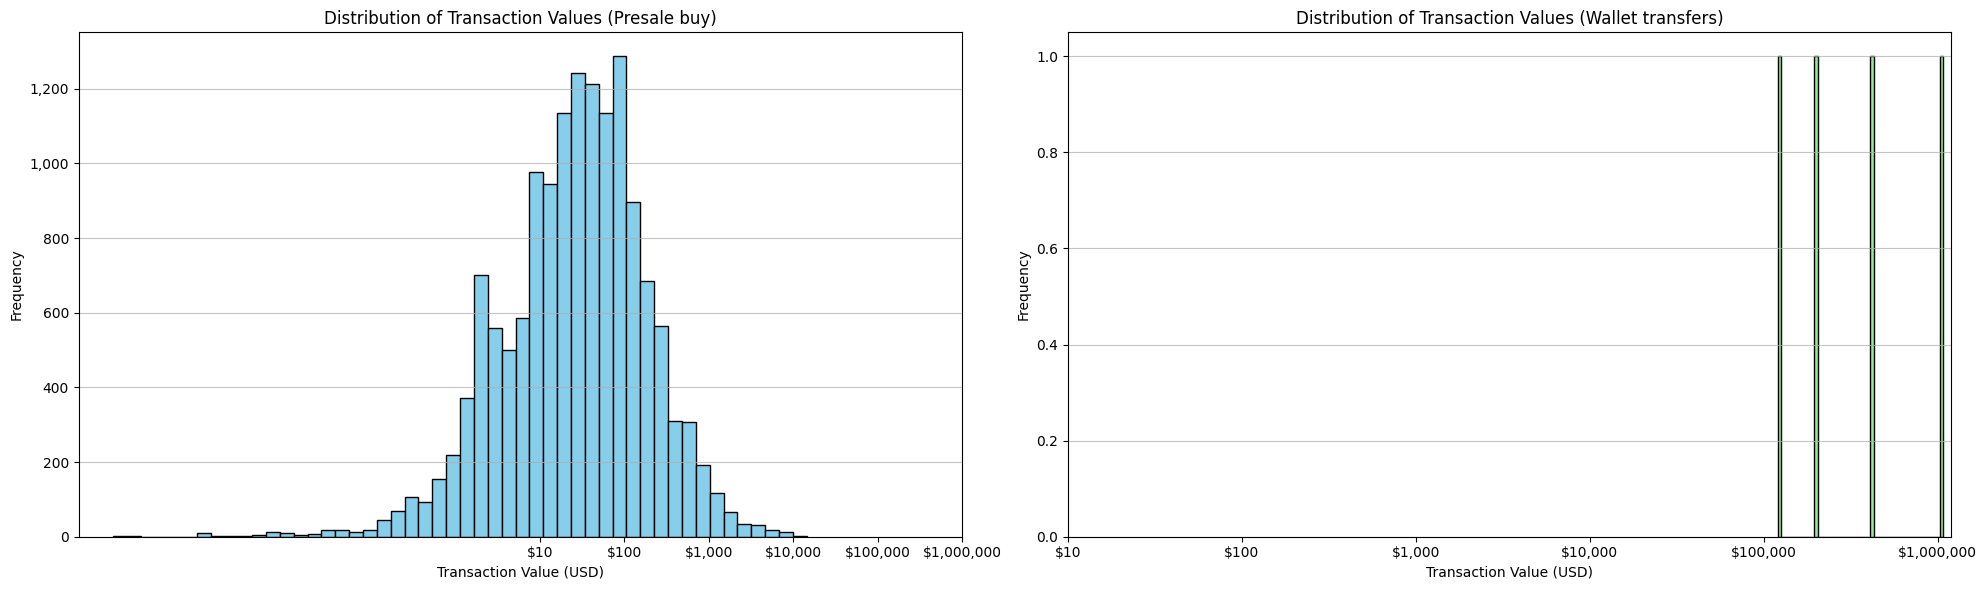

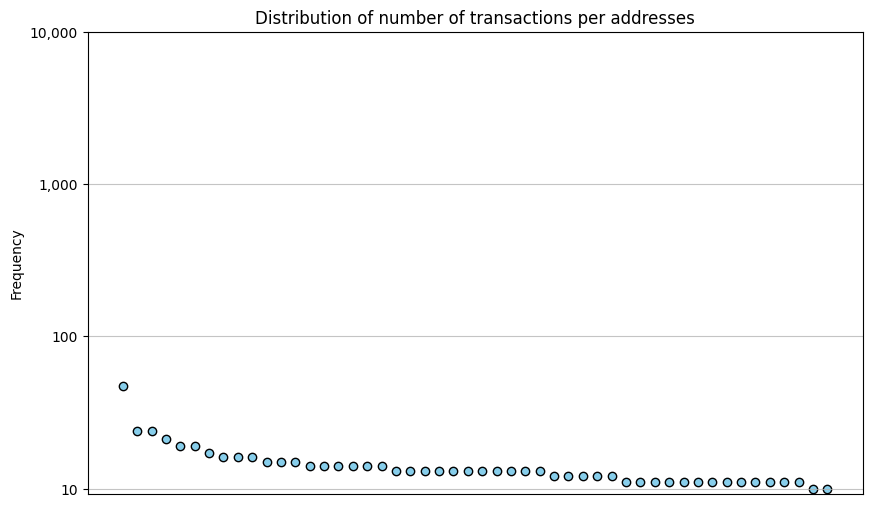

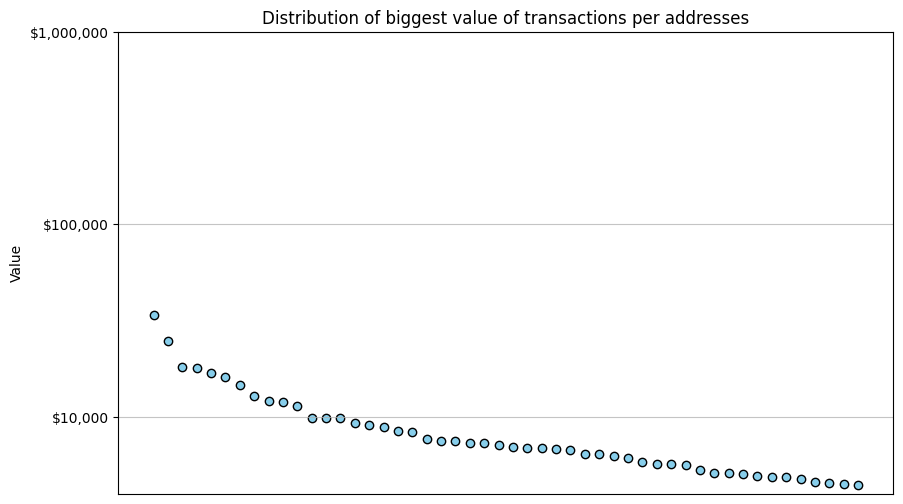

unique:  2 transfer_sum:  2


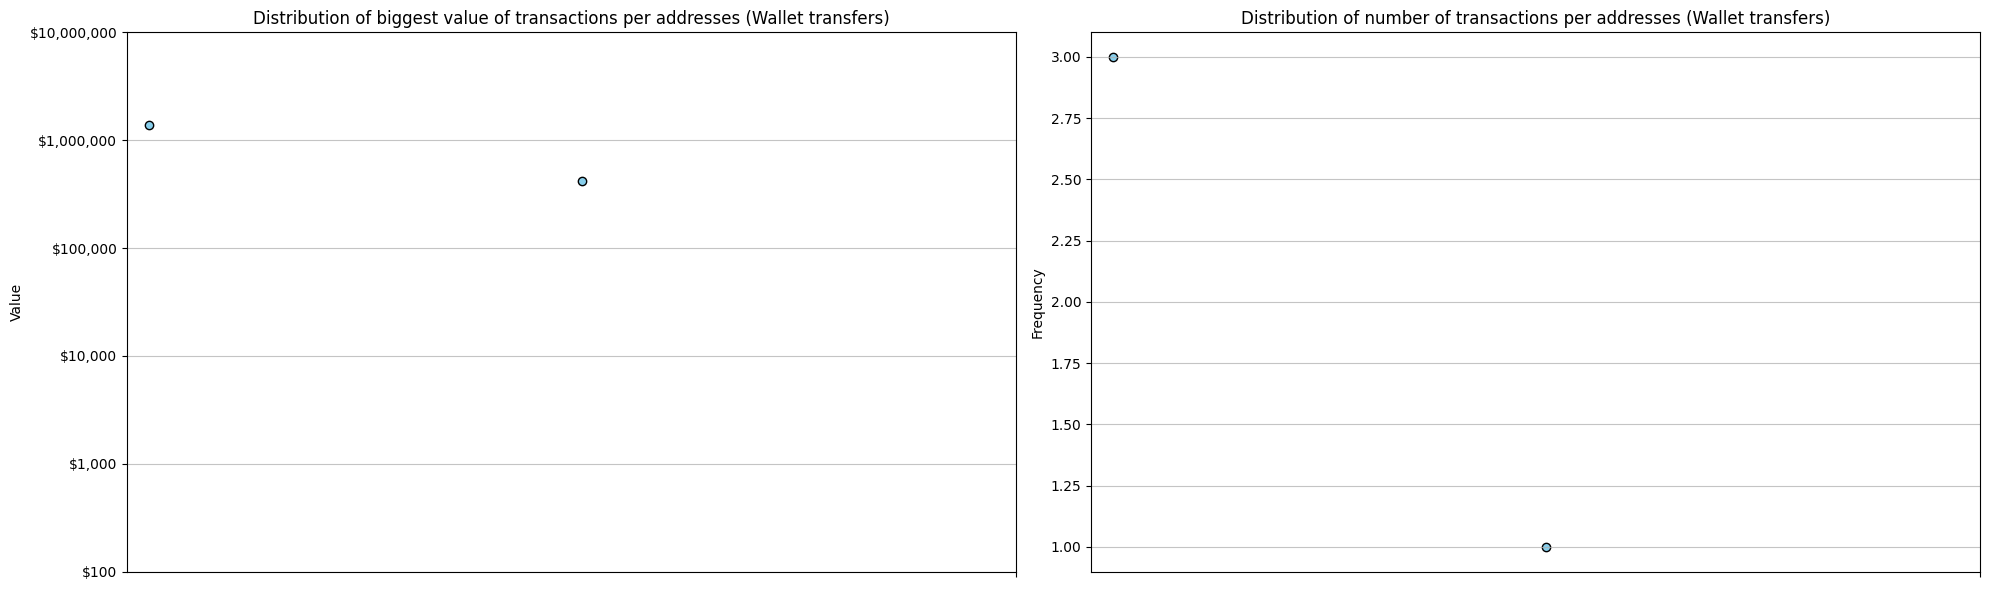

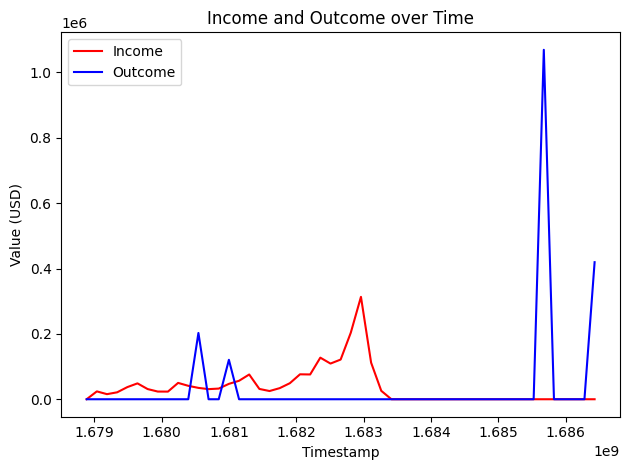

In [6]:
data_path = '../Data/DATA_Love_Hate_Inu_presale.xlsx'
data_sheet_out = 'lhinu_bsc_payment_wallet_transf'
data_sheet_in = 'lhinu_bsc_presale_buys_26487457'
network = 'Love_Hate_LNU'

analiser = Crypto_analiser(data_path=data_path, 
                                  data_sheet_in=data_sheet_in, 
                                  data_sheet_out=data_sheet_out,
                                  network=network)
analiser.make_all_plots()

## Thug life token

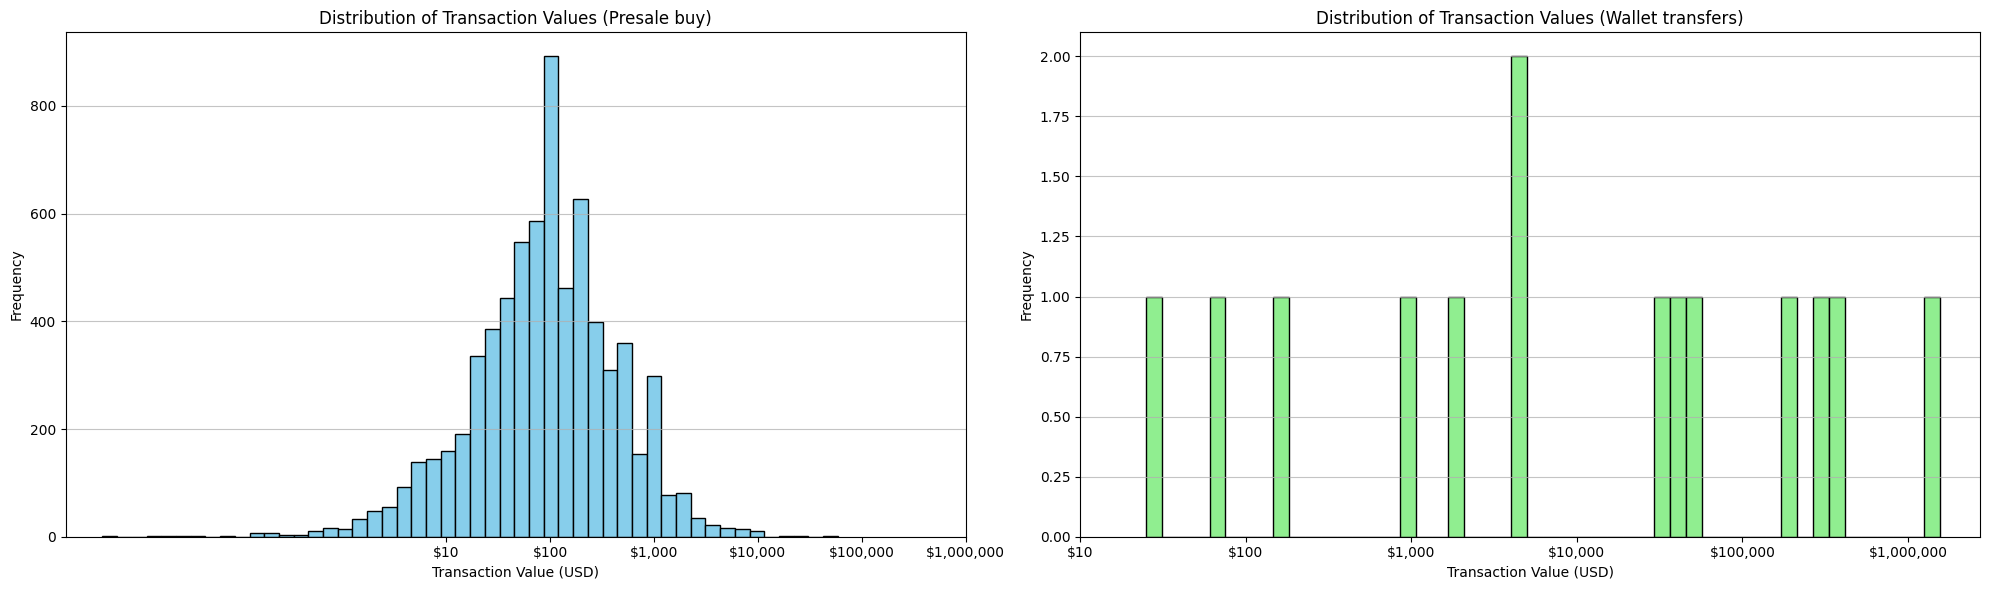

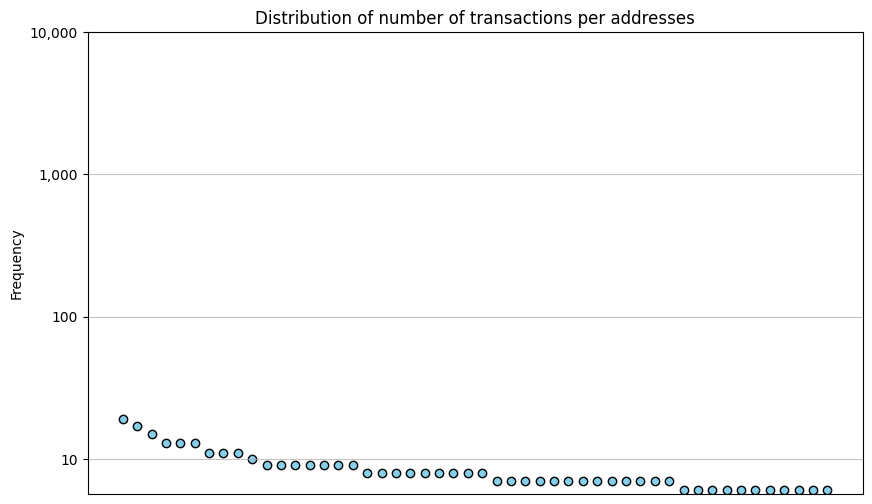

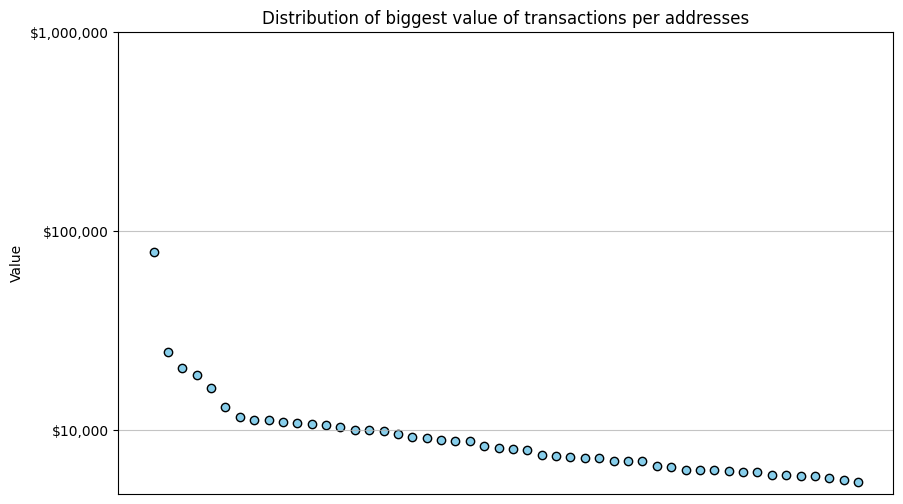

unique:  15 transfer_sum:  15


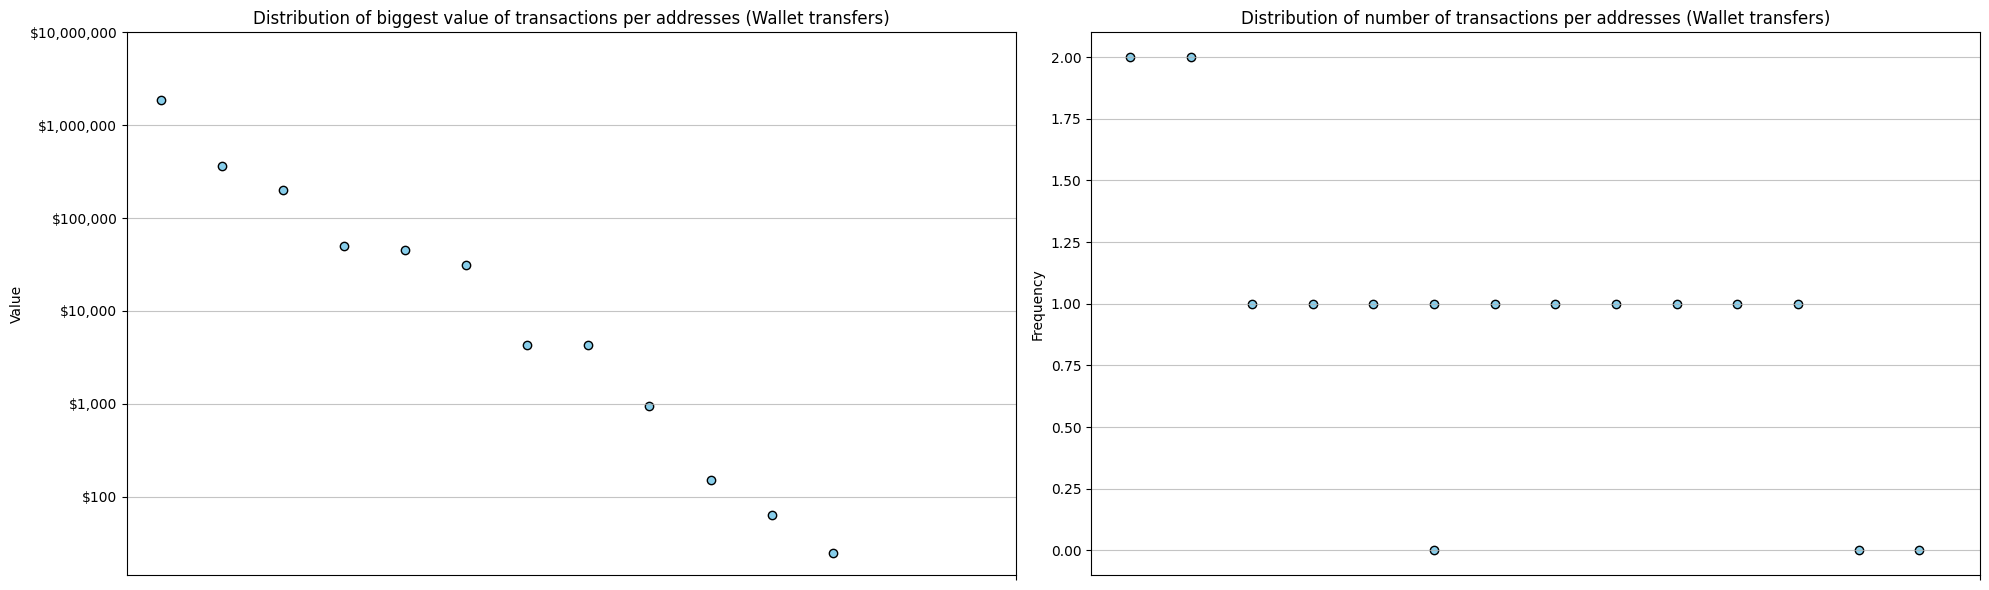

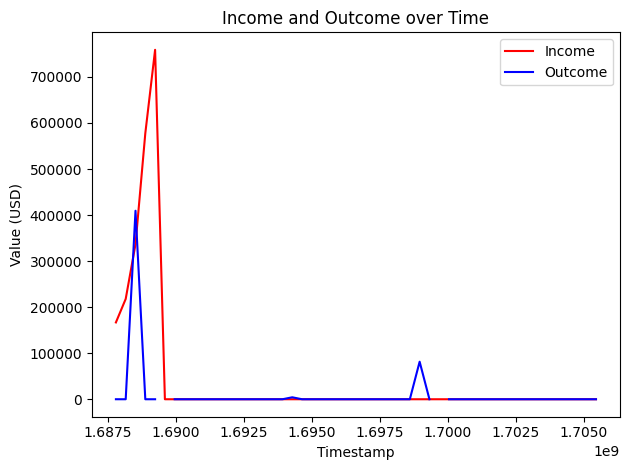

In [14]:
data_path = '../Data/Thug_Life_token_presale.xlsx'
data_sheet_out = 'thug_payment_wallet_transfers_ '
data_sheet_in = 'thug_presale_buy_result_1756436'
network = 'Thug_Life_Token'

analiser = Crypto_analiser(data_path=data_path, 
                                  data_sheet_in=data_sheet_in, 
                                  data_sheet_out=data_sheet_out,
                                  network=network)
analiser.make_all_plots()

## Wall Street Memes

### BSC

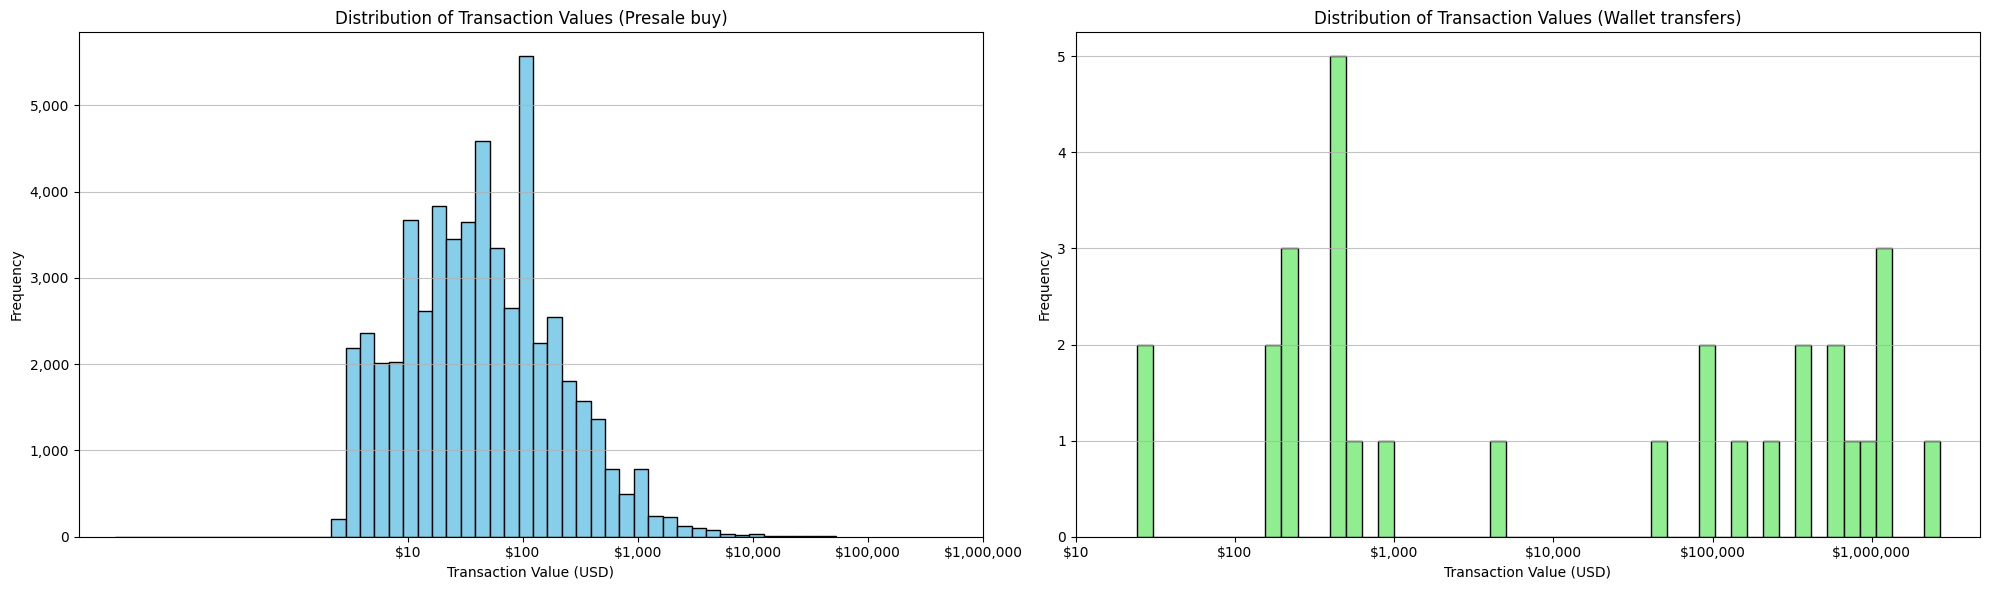

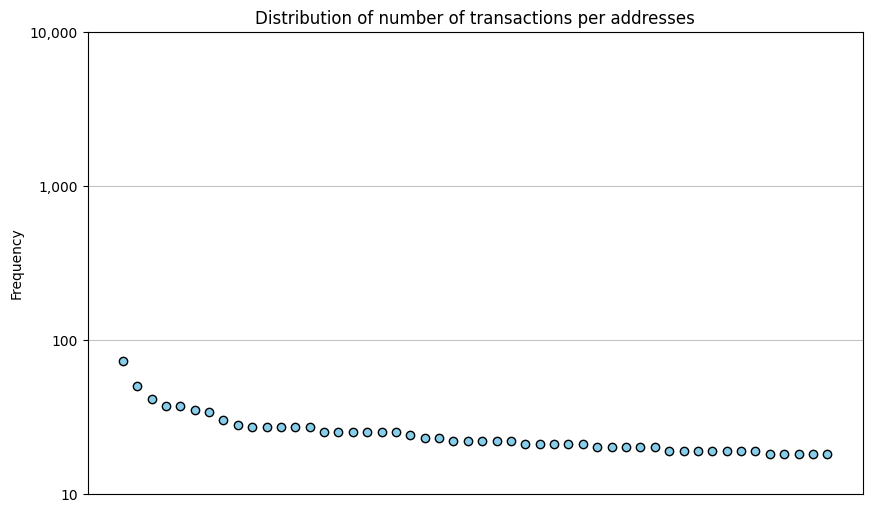

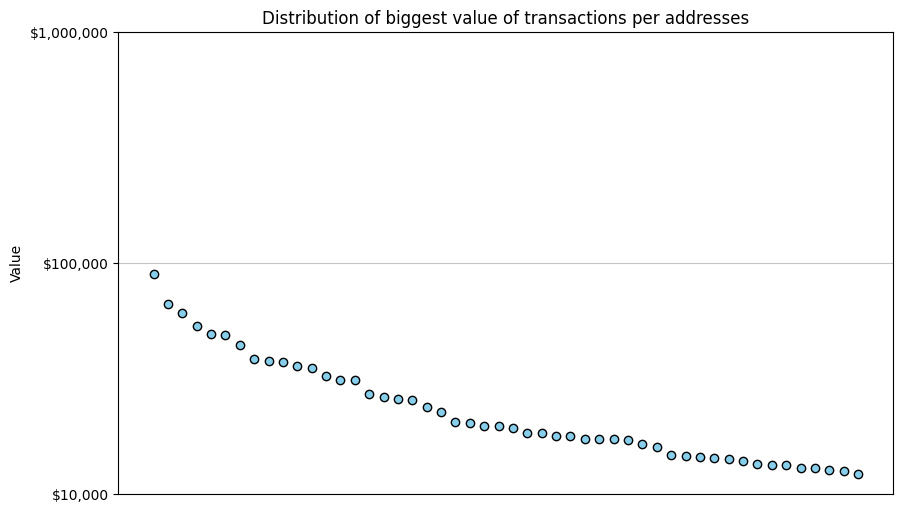

unique:  15 transfer_sum:  15


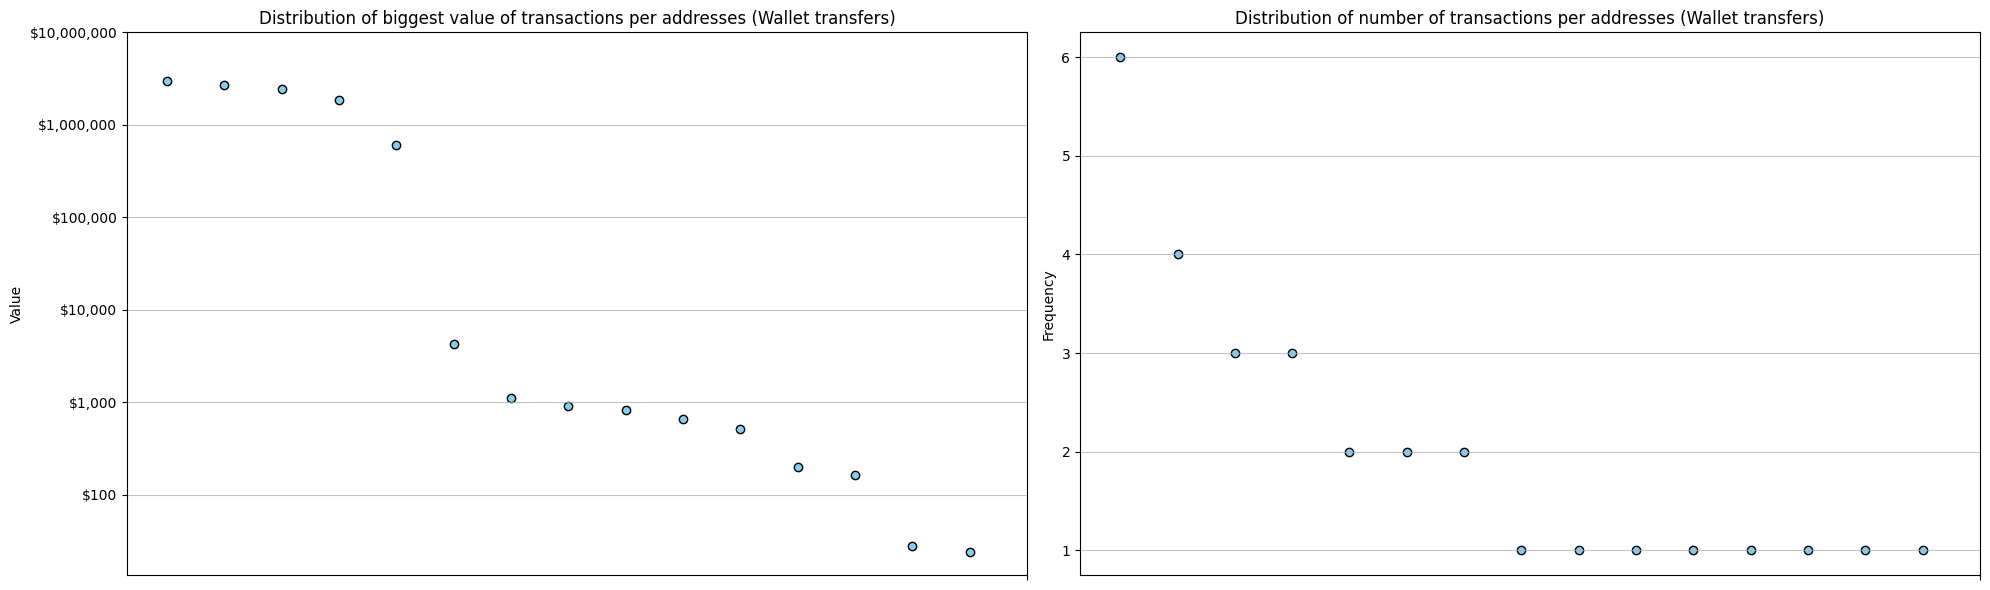

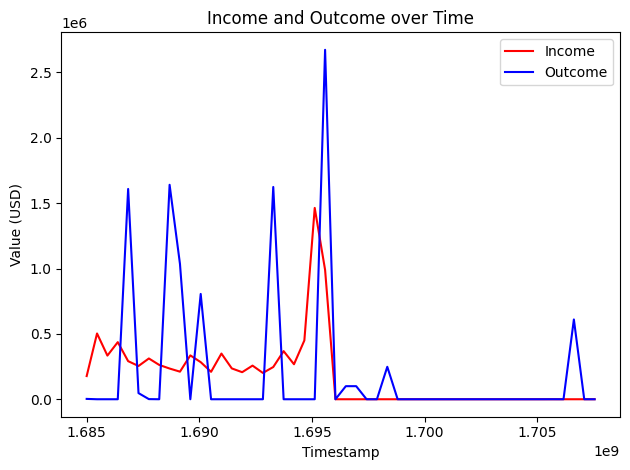

In [8]:
data_path = '../Data/Wall_Street_Memes_presale.xlsx'
data_sheet_out = 'wsm_payment_wallet_transfers_bs'
data_sheet_in = 'wsm_presale_buy_result_bsc_2851'
network = 'Wall_Street_Memes'

analiser = Crypto_analiser(data_path=data_path, 
                                  data_sheet_in=data_sheet_in, 
                                  data_sheet_out=data_sheet_out,
                                  network=network)
analiser.make_all_plots()

### ETH

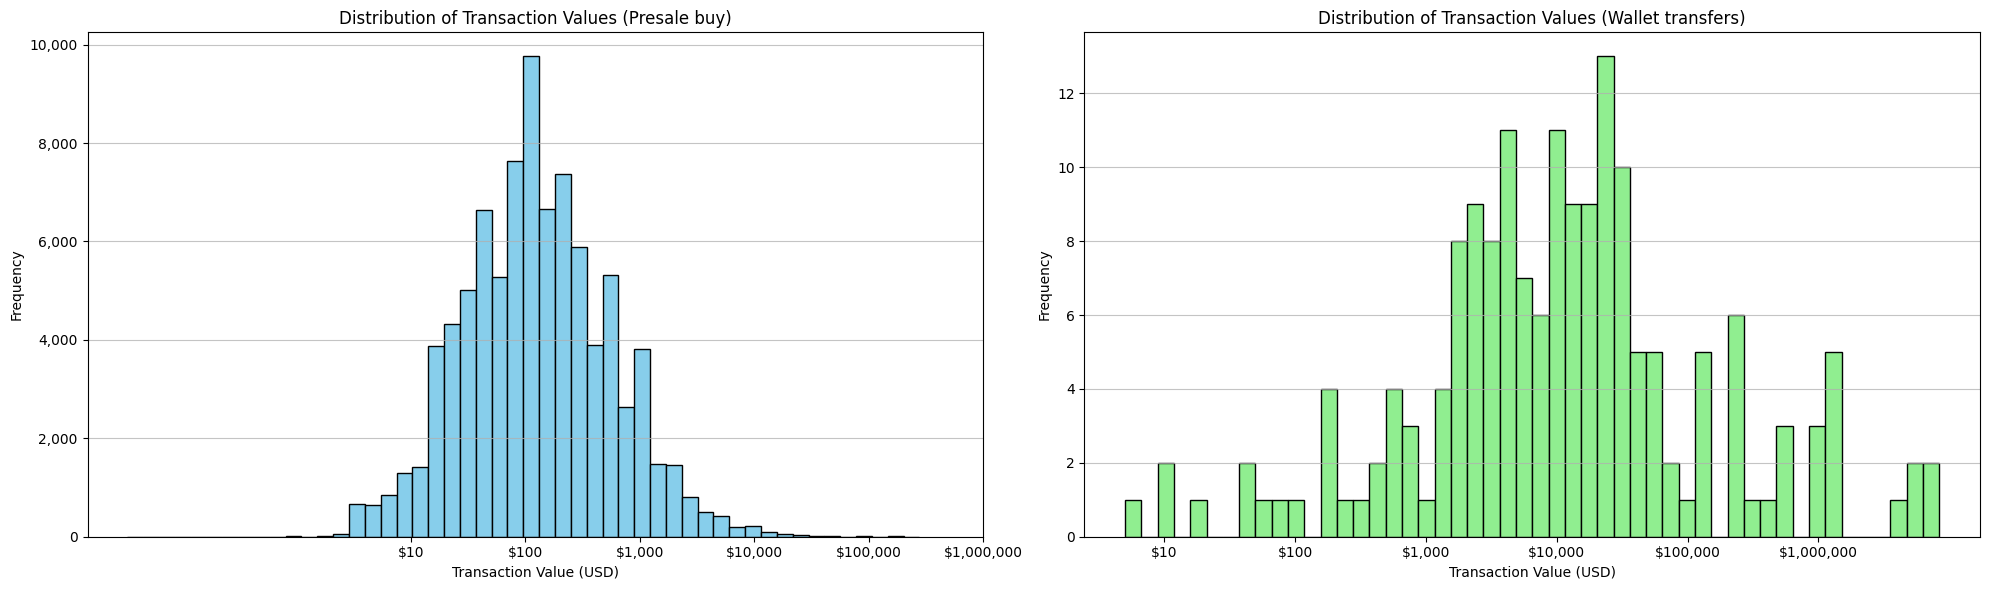

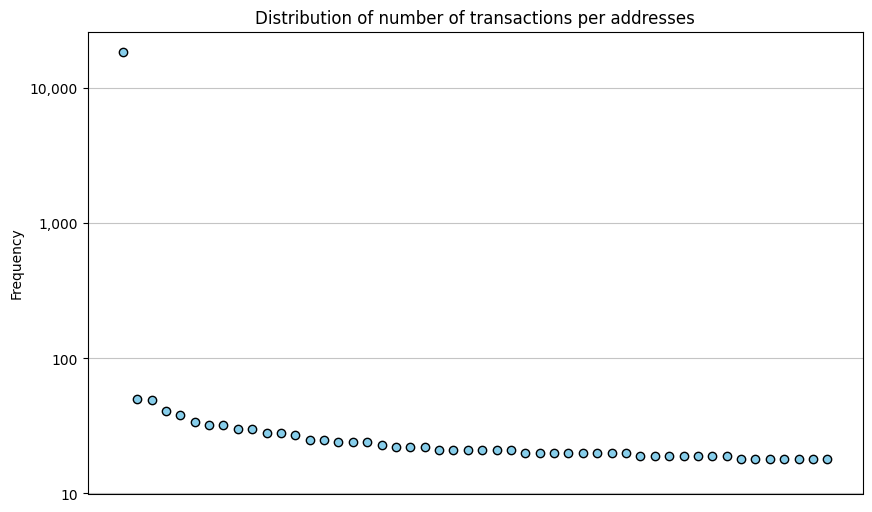

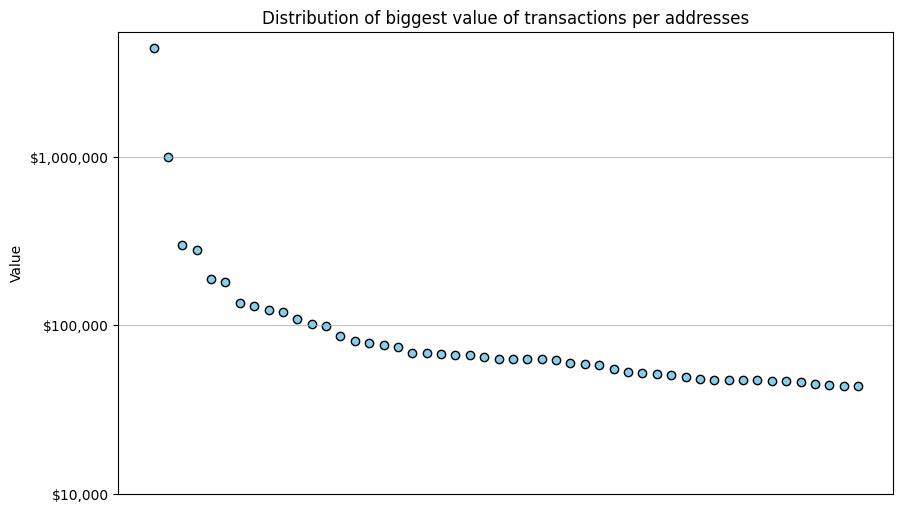

unique:  32 transfer_sum:  32


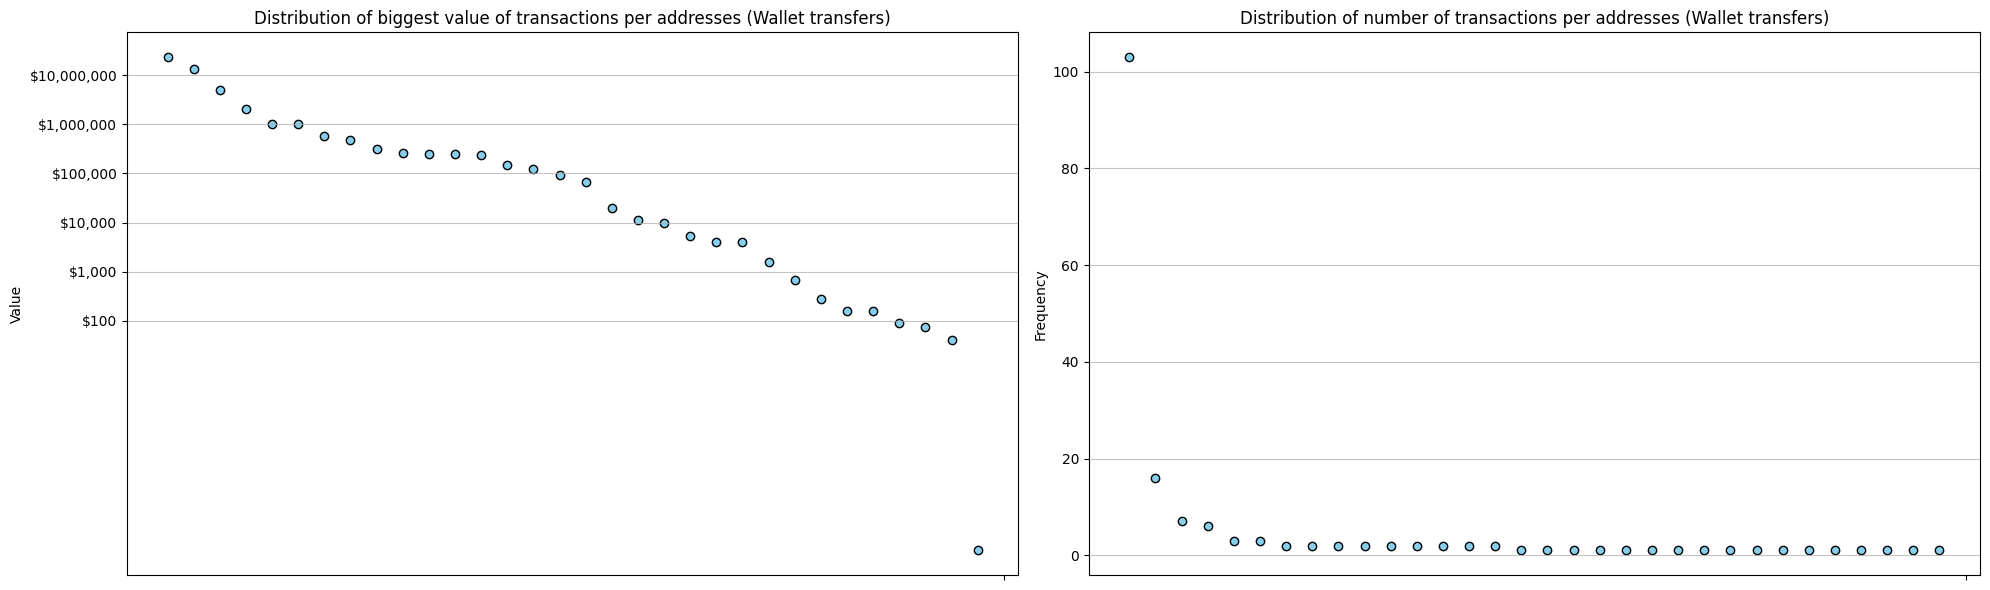

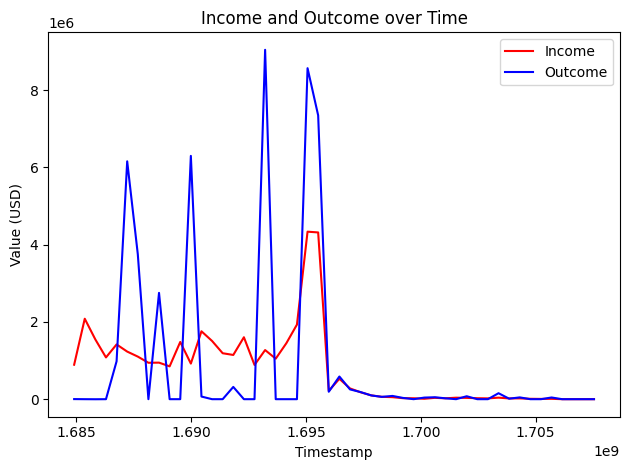

In [9]:
data_path = '../Data/Wall_Street_Memes_presale.xlsx'
data_sheet_out = 'wsm_payment_wallet_transfers_et'
data_sheet_in = 'wsm_presale_buy_result_eth_1733'
network = 'Wall_Street_Memes'

analiser = Crypto_analiser(data_path=data_path, 
                                  data_sheet_in=data_sheet_in, 
                                  data_sheet_out=data_sheet_out,
                                  network= network)
analiser.make_all_plots()

# Concatenating all the data into 1 sheet

In [20]:
data_paths_sheets = [('../Data/DATA_Love_Hate_Inu_presale.xlsx', 'lhinu_payment_wallet_transfers_', 'lhinu_presale_buy_result_167775', 'Love_Hate_LNU'),
                     ('../Data/DATA_Love_Hate_Inu_presale.xlsx', 'lhinu_bsc_payment_wallet_transf', 'lhinu_bsc_presale_buys_26487457', 'Love_Hate_LNU'),
                     ('../Data/Thug_Life_token_presale.xlsx', 'thug_payment_wallet_transfers_ ', 'thug_presale_buy_result_1756436', 'Thug_Life_Token'),
                     ('../Data/Wall_Street_Memes_presale.xlsx', 'wsm_payment_wallet_transfers_bs', 'wsm_presale_buy_result_bsc_2851', 'Wall_Street_Memes'),
                     ('../Data/Wall_Street_Memes_presale.xlsx', 'wsm_payment_wallet_transfers_et', 'wsm_presale_buy_result_eth_1733', 'Wall_Street_Memes')]
data = []
for data_path, data_sheet_in, data_sheet_out, network in data_paths_sheets:
    analiser = Crypto_analiser(data_path=data_path, 
                                    data_sheet_in=data_sheet_in, 
                                    data_sheet_out=data_sheet_out,
                                    network=network)
    data.append(analiser.data_transfers_out[['from_address', 'to_address', 'value_in_usd']])
    data.append(analiser.data_transfers_in[['from_address', 'to_address', 'value_in_usd']])

In [19]:

result = pd.concat(data, ignore_index=True)
result.to_csv('../Data/All_Transfers_Reduced.csv')
result

,from_address,to_address,value_in_usd
0,0x13f449f1d18113242f4b4f822fe775eb8dcbfadb,0x17b1e028a1837ff15ba9e7140add0d13790092a3,20.200250
1,0xc501feef312f6a7843334a2bc8eff3cad60b7e25,0x17b1e028a1837ff15ba9e7140add0d13790092a3,156.329960
2,0xc501feef312f6a7843334a2bc8eff3cad60b7e25,0x17b1e028a1837ff15ba9e7140add0d13790092a3,156.329960
3,0xc501feef312f6a7843334a2bc8eff3cad60b7e25,0x17b1e028a1837ff15ba9e7140add0d13790092a3,85.000000
4,0x13f449f1d18113242f4b4f822fe775eb8dcbfadb,0x17b1e028a1837ff15ba9e7140add0d13790092a3,1.700000
...,...,...,...
190729,0xacfc50ec5fe0fd039e83380b8ab343b77a49704f,0xae871521c908b65dd3bec3f04252abac6f9e1673,-610045.907727
190730,0xe3d595aaa904693d4f8ae58919fa8ae3fa039583,0xb119efffe20d57f3a2b71654c745a137c9c991af,40.260000
190731,0xae871521c908b65dd3bec3f04252abac6f9e1673,0x242a31020edde68acf751b2d2a1071dd08b9bfdd,605377.500000
190732,0x242a34d8ace06619b3649abbdac6a5355b68bfdd,0xae871521c908b65dd3bec3f04252abac6f9e1673,-0.006054


# Taking a look at the intersections between presale and output wallets

## Direct intersection, just inside the one presale

In [56]:
data_paths_sheets = [('../Data/DATA_Love_Hate_Inu_presale.xlsx', 'lhinu_payment_wallet_transfers_', 'lhinu_presale_buy_result_167775', 'Love_Hate_LNU_eth'),
                     ('../Data/DATA_Love_Hate_Inu_presale.xlsx', 'lhinu_bsc_payment_wallet_transf', 'lhinu_bsc_presale_buys_26487457', 'Love_Hate_LNU_bsc'),
                     ('../Data/Thug_Life_token_presale.xlsx', 'thug_payment_wallet_transfers_ ', 'thug_presale_buy_result_1756436', 'Thug_Life_Token'),
                     ('../Data/Wall_Street_Memes_presale.xlsx', 'wsm_payment_wallet_transfers_bs', 'wsm_presale_buy_result_bsc_2851', 'Wall_Street_Memes_bsc'),
                     ('../Data/Wall_Street_Memes_presale.xlsx', 'wsm_payment_wallet_transfers_et', 'wsm_presale_buy_result_eth_1733', 'Wall_Street_Memes_eth')]

intersections = {}
for data_path, data_sheet_in, data_sheet_out, network in data_paths_sheets:
    analiser = Crypto_analiser(data_path=data_path, 
                                    data_sheet_in=data_sheet_in, 
                                    data_sheet_out=data_sheet_out,
                                    network=network)
    output = analiser.data_transfers_out[['from_address', 'to_address', 'value_in_usd']]
    input = analiser.data_transfers_in[['from_address', 'to_address', 'value_in_usd']]

    intersections[network] = set(output['to_address']).intersection(set(input['from_address']))

In [57]:
intersections

{'Love_Hate_LNU_eth': set(),
 'Love_Hate_LNU_bsc': set(),
 'Thug_Life_Token': set(),
 'Wall_Street_Memes_bsc': set(),
 'Wall_Street_Memes_eth': set()}

## All together, input and output wallets

In [68]:
intersection_wallets = set(result.to_address).intersection(set(result.from_address))
intersection_wallets

{'0x19beec2fa10f46224d9dae7654c085887f42cedc',
 '0x1eae40867c9861086e35d8239e9615359ff34d1b',
 '0x2b705be9e6bb547619b5ea7c1e348fb80de0da5d',
 '0x4b9c6933e17a12cf79759c5ec74963b1ab3c71d2',
 '0x4d1a66dd90da5834318bde19211d6e22c126459d',
 '0x5be3ce2647f9e860ab1eadbc155c060a87b7d789',
 '0x6604126291b912452e202edbf25d0a31b932dcfe',
 '0x99a2770b5c9337f44a00a7677471373c89bf0f36',
 '0xae871521c908b65dd3bec3f04252abac6f9e1673',
 '0xb96b628ebb6ab7b978952f04f1c27ac246f4fc46',
 '0xc731c91d4640700a7211bc60786f00d8fe95fd45',
 '0xd3f2d401feca01f59c8f8520e7b55d7655d7cd0f',
 '0xdce58027e3b2f150648d6f1c99c4805fcbcea75a',
 '0xe3d595aaa904693d4f8ae58919fa8ae3fa039583',
 '0xe51cd412911f4910e9be55200411fb01f41e97b0',
 '0xe780f14e4b3328bd51c4bf7eec59452c745d8aa2'}

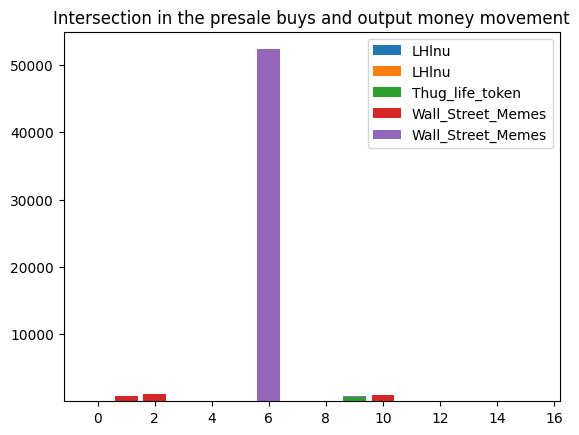

In [64]:
def inspect_list_of_buyers(all_data_source: list, source_names: list, buyers):
    all_buyers = {}
    moneys_spent = {x: [0] * len(all_data_source) for x in buyers}  # Track spending by each buyer for each data source

    for i in range(len(all_data_source)):
        data = all_data_source[i]
        df = pd.read_excel(data['data_path'], sheet_name=data['data_sheet'])
        for buyer in buyers:
            this_buyer = df[df['from_address'] == buyer]
            all_buyers[(buyer, source_names[i])] = this_buyer
            money_spent = this_buyer['value_in_usd'].sum()
            moneys_spent[buyer][i] = money_spent

    # Prepare data for plotting
    buyers_list = list(buyers)
    data_sources = len(all_data_source)
    ind = np.arange(len(buyers))  # the x locations for the groups
    bottom = np.zeros(len(buyers))  # Starting bottom for each buyer's bar

    fig, ax = plt.subplots()

    for i in range(data_sources):
        amounts = [moneys_spent[buyer][i] for buyer in buyers_list]
        bars = ax.bar(ind, amounts, bottom=bottom, label=source_names[i])
        bottom += np.array(amounts)  # Update bottom for next data source

    ax.legend()  # Add legend to differentiate data sources
    plt.title('Intersection in the presale buys and output money movement')
    plt.show()

inspect_list_of_buyers(all_data_source, source_names, intersection_wallets)

In [70]:
intersection_wallet_data = result[result['to_address'].isin(intersection_wallets) | result['from_address'].isin(intersection_wallets)]
intersection_wallet_data

,from_address,to_address,value_in_usd
25480,0x4b9c6933e17a12cf79759c5ec74963b1ab3c71d2,0x17b1e028a1837ff15ba9e7140add0d13790092a3,1.450000e-04
25684,0x99a2770b5c9337f44a00a7677471373c89bf0f36,0x7ef72849187a2901eb3843af319cfd3240fe8971,1.334133e+05
25685,0x99a2770b5c9337f44a00a7677471373c89bf0f36,0x4b9c6933e17a12cf79759c5ec74963b1ab3c71d2,3.312400e+02
25686,0x99a2770b5c9337f44a00a7677471373c89bf0f36,0x48491f438fcb7b98b97c036627bac7b6af62d5ca,4.434514e+05
25687,0x99a2770b5c9337f44a00a7677471373c89bf0f36,0x48491f438fcb7b98b97c036627bac7b6af62d5ca,1.052850e+06
...,...,...,...
190729,0xacfc50ec5fe0fd039e83380b8ab343b77a49704f,0xae871521c908b65dd3bec3f04252abac6f9e1673,-6.100459e+05
190730,0xe3d595aaa904693d4f8ae58919fa8ae3fa039583,0xb119efffe20d57f3a2b71654c745a137c9c991af,4.026000e+01
190731,0xae871521c908b65dd3bec3f04252abac6f9e1673,0x242a31020edde68acf751b2d2a1071dd08b9bfdd,6.053775e+05
190732,0x242a34d8ace06619b3649abbdac6a5355b68bfdd,0xae871521c908b65dd3bec3f04252abac6f9e1673,-6.053775e-03


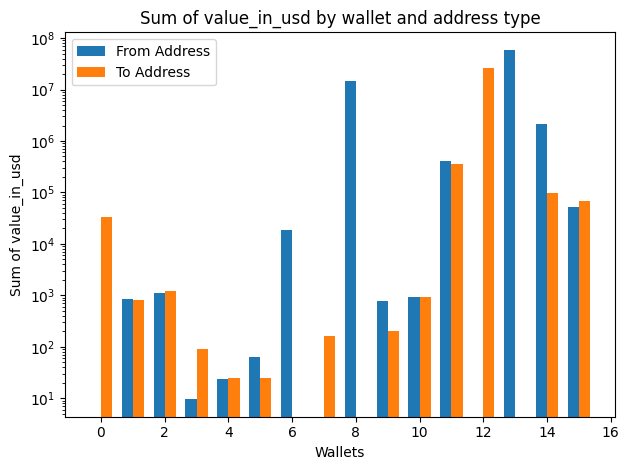

In [73]:
# Initialize dictionaries to store sums
from_sums = {wallet: 0 for wallet in intersection_wallets}
to_sums = {wallet: 0 for wallet in intersection_wallets}

# Calculate sums
for wallet in intersection_wallets:
    from_sums[wallet] = intersection_wallet_data[intersection_wallet_data['from_address'] == wallet]['value_in_usd'].sum()
    to_sums[wallet] = intersection_wallet_data[intersection_wallet_data['to_address'] == wallet]['value_in_usd'].sum()

# Prepare data for plotting
wallets = list(intersection_wallets)
from_values = [from_sums[wallet] for wallet in wallets]
to_values = [to_sums[wallet] for wallet in wallets]

# Plotting
x = np.arange(len(wallets))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, from_values, width, label='From Address')
rects2 = ax.bar(x + width/2, to_values, width, label='To Address')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_yscale('log')
ax.set_xlabel('Wallets')
ax.set_ylabel('Sum of value_in_usd')
ax.set_title('Sum of value_in_usd by wallet and address type')
ax.legend()

fig.tight_layout()

plt.show()